# **Proyecto Final Modulo 2 Programa de Formación en Data Science y Machine Learning**
# Universidad Nacional de Colombia, Facultad de Ingeniería

Presentado por: **Julián Andrés Santos Méndez**

email: ingjuliansantos@gmail.com


# **1. Entendimiento del Negocio**
---

## **1.1. Objetivos de negocio y situación actual**
---

Colombia es un país que se enorgullese de que el 69.25% de su energía eléctrica es generada con recursos renovables, los cuales constituyen una matriz energetica no fósil muy variada con diferentes fuentes, tales como la energía hidráulica, la biomasa, la energía eólica y la energía solar, sin embargo, el 98.5% de esa energía es generada con recursos hidráulicos a gran escala. 

Como consecuencia de esa depedencia a los grandes embalses, se tiene un sistema eléctrico que es muy sensible a fenomenos climáticos como el fenomeno del niño.

*Tabla 1. Capacidad efectiva neta del Sistema Interconectado Nacional (SIN) por tipo de recurso natural, Fuente: Informe 2019 XM S.A. E.S.P. [1]*

| Fuente de energía               | 2018 MW   | 2019 MW   | Participación (%) | Variación 2019 vs. 2018 |
|---------------------------------|-----------|-----------|-------------------|-------------------------|
| **Fuentes de energía No Renovable**
| Combustible fósil               | 5,308.14  | 5,369.74  | 30.75%            | 1.16%                   |
| Total No Renovable              | 5,308.14  | 5,369.74  | 30.75%            | 1.16%                   |
| **Fuentes de energía Renovable**    
| Biomasa                         | 139.60    | 139.60    | 0.80%             | 0.00%                   |
| Eólica                          | 18.42     | 18.42     | 0.11%             | 0.00%                   |
| Hidráulica                      | 11,836.57 | 11,916.61 | 68.24%            | 0.68%                   |
| Solar                           | 9.80      | 17.98     | 0.10%             | 83.43%                  |
| **Total Renovable**                 | **12,004.39** | **12,092.60** | **69.25%**           | **0.73%**                   |
| **Total general**                  | **17,312.53** | **17,462.34** | **100.00%**           | **0.87%**                   |

Para contrarrestar esa dependecia a la energía hidráulica, el país inició el proceso de incoporación de mas activos de generacion térmica con combustibles fósiles[2].

Es por esta razón que **el objetivo** principal de este proyecto es hacer un seguimiento de las emisiones de gases contaminantes que ha hecho el sistema eléctrico Colombiano y determinar su relacion con otras variables del sistema, para así tener una base con la cual analizar en el futuro las emisiones de los nuevos activos térmicos.

## **1.2. Metas del proyecto de Machine Learning**
---

Como continuación del proyecto del primer modulo, las metas de este proyecto son:
1. Seleccionar un modelo de aprendizaje automático para predecir la emisiones de $CO_2$ equivalente del sistema eléctrico colombiano, como serie de tiempo.


## **1.3. Planeación del proyecto de Machine Learning**
---

A continuacion se presenta el plan para la ejecución del presente proyecto:

1. **Definición de las fuentes de información.**
  * *Application Programming Interface* tipo REST (API) de XM S.A. E.S.P.
  * *Web scraping* del informe diario de operación (IDO) de XM S.A. E.S.P.
  * Se solicitaron, al *servicio al ciudadano* de XM S.A. E.S.P., los datos de ubicación de las centrales de generacion del Sistema Eléctrico Colombiano.
2. **Caracterización de los datos**
  * Verificación del tamaño y forma del DataFrame consolidado
  * Verificación de los tipos de dato.
  * Verificación de las unidades de medida de cada *feature*.
3. **Preparación de los datos**
  * Selección de características
4. **Modelamiento**
  * Selección de los modelos a evaluar
  * Diseño de los experimientos de validacion cruzada
  * Entrenamiento de los modelos
  * Definición de los criterios o métricas de evaluación
5. **Evaluación**
  * Análisis de los resultados

## **1.4. Herramientas del proyecto**
---

En este proyecto fueron usadas las siguientes Librerias:
1. Pandas
2. Matplotlib
3. Seaborn
4. Scikit learn

Tambien se usaron los siguientes entornos de desarrollo:
1. Colab


In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# Configuraciones para las librerías y módulos usados.

# Ignoramos las advertencias o warnings.
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la 
# librería de visualización Matplotlib.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 105
mpl.rcParams['figure.figsize'] = (9, 7)

In [234]:
!pip install -U plotly
import plotly
import plotly.graph_objects as go

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


## **1.5. Definiciones importantes**
---

*   **XM S.A. E.S.P.**: Es una empresa que pertenece al grupo ISA, se encarga de la administración del mercado mayorista de electricidad de Colombia, también opera el Sistema Interconectado Nacional, integrando así, sus recursos de generación, interconexión y transmisión de energía eléctrica.[3]  
*   **Emisiones Contaminantes**: Es la descarga de fluidos gaseosos, puros o con sustancias en suspensión que sean residuos de la actividad humana o de la naturaleza y que causan efectos adversos en la atmósfera de la tierra, como lo es el efecto invernadero o lluvia ácida.
* $CO_{2}$: Dioxido de carbon, gas contaminante de la atmosfera el cual produce efecto invernadero.
* $CH_{4}$: Metano, gas contaminante de la atmosfera, el cual produce efecto invernadero con un potencial de calentamiento global 21 veces mayor que el $CO_{2}$.
* $N_{2}O$: Oxido Nitroso, gas contaminante de la atmosfera, el cual produce efecto invernadero con un potencial de calentamiento global 310 veces mayor que el $CO_{2}$.
* $CO_{2 eq}$: Emisiones de un gas equivalentes a $CO_{2}$, se calcula con la siguiente formula $Ton CO_{2 eq} = (TonGas) (GWP)$, donde GWP es el potencial de calentamiento global.


## **1.6. Funciones de apoyo**
---

In [235]:
def plot_prediction_new(params, ys, test_date_index): 
  
  train_data = df_CO2_ts['daily_emision_CO2_eq'].loc[:test_date_index[0]]
  _y_test, _y_forward = ys
  # Graficamos los valores predichos.
  fig = go.Figure(layout = dict(
       title = f'<b>Emisiones de CO2 del Sistema Eléctrico Colombiano</b> <br> {params}',
       dragmode= 'pan', width = 1200, height = 600))
  
  fig.add_trace(go.Scatter(x = train_data.index,  # Datos originales hasta la primer semana predicha. (fechas)
                          y = train_data.values, # Datos originales hasta la primer semana predicha. (temperaturas)
                          mode = 'lines',
                          name = 'Valores de entrenamiento y pruebas'))

  #Gráfica de los valores de prueba reales.
  fig.add_trace(go.Scatter(x = test_date_index,
                          y = _y_test,
                          mode='lines+markers',
                          name='Valores reales (y)'))


  #Gráfica de los valores predichos a partir de las ventanas de X_test.
  fig.add_trace(go.Scatter(x = test_date_index, 
                          y = _y_forward,
                          mode = 'lines+markers',
                          name = 'Valores predichos a partir de datos reales'))

  fig.show(config = dict({'scrollZoom': True})) 

In [236]:
# Función para obtener las ventanas de tiempo.

def sliding_time(ts, window_size=1):

  n = ts.shape[0] - window_size  
  X = np.empty((n, window_size))
  y = np.empty(n)

  for i in range(window_size, ts.shape[0]):   
    y[i - window_size] = ts[i]
    X[i- window_size, 0:window_size] = np.array(ts[i - window_size:i])
    
  return X, y

# **2. Caracterización de los datos**
---

## 2.1. Definición de las variables
---

A cotinuacion se hace una definición del siginificado de cada una de las variables de operación del Sistema Interconectado Nacional:
* **Generación**: Es la cantidad de energía eléctrica generada por el SIN.
* **Demanda**: Es la cantidad de energía eléctrica demandada por los consumidores del SIN.
* **Disponibilidad Real**: Es la capacidad instalada, activos listos para generar, que esta en capacidad de comenzar a generar energía de inmediato.
* **Aportes de Energía**: Son los aportes hídricos que llegan llegan al SIN por medio de los embalses que lo componen, en lugar de caudal, se presentan en unidades de energía, lo que dice directamente cuanta eléctricidad es capaza de generar esa cantidad de agua.
* **Volumen Util**: Es el volumen útil de agua que tienen los embalses del SIN, es decir, con capacidad de generar energía, al igual que los aportes, se mide en energía.
* **Consumo de Combustible**: Es la cantidad de combustible fósil usado por el SIN.
* **Precio Bolsa**: El precio de la bolsa mayorista de energía del SIN.
* **Emisiones**: Para cada uno de los gases contaminantes, representa la cantidad en toneladas de ese gas, que descarga el sistema a la atmósfera. Solo incluye los gases generados directamente por las plantas al quemar combustible para generar.  

## **2.1. Unidades de medida y conversión**
---

En la siguiente tabla se muestran las unidades de medida actuales del dataset y las unidades a las cuales se hara conversion para tener un manejo mas adecuado de las magnitudes.

| Variable (Feature)         | Unidad Actual | Unidad a Convertir |
|----------------------------|---------------|--------------------|
| daily_generacion         | kWh           | GWh                |
| daily_emision_CO2          | Ton           | Ton                |
| daily_emision_CH4          | Ton           | Ton                |
| daily_emision_N2O          | Ton           | Ton                |
| daily_consumo_combustible  | MBTU          | MMBTU              |
| daily_demanda              | kWh           | GWh                |
| daily_aportes_energia      | kWh           | GWh                |
| daily_volumen_util_energia | kWh           | GWh                |
| daily_disponibilidad_real  | MW            | GWh*               |
| daily_precio_bolsa         | COP/kWh       | COP/kWh            |

*La disponibilidad_real es dada en MW de potencia disponible para generar eléctricidad, sin embargo esta unidad no es compatible con las unidades de energía que manejan las otras variables. 

Por esta razón se hace el cálculo de la disponibilidad energética real promedio por día el cual consiste en multiplicar la unidad de potencia por las 24 horas del día.

## **2.2. Adquisición e integración de datos**
---

Los datos para este proyecto fueron preparados en el proyecto final del modulo 1. Ver Notebook adjunto.
Estos datos se consolidaron a partir de los datasets adquiridos en:
  * La *Application Programming Interface* tipo REST (API) de XM S.A. E.S.P.
  * Del *Web scraping* del informe diario de operación (IDO) de XM S.A. E.S.P.
  * Y también se solicitaron al *servicio al ciudadano* de XM S.A. E.S.P., los datos de ubicación de las centrales de generacion del Sistema Eléctrico Colombiano.

In [237]:
df_power_co = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado Machine Learning and Data Science/Modulo 2 Introducción a Machine Learning/Proyecto Final/data/clean_dataset/power_system.csv')
df_power_co

Unnamed: 0        Date  ...  daily_precio_bolsa  daily_emision_CO2_eq
0              0  2013-10-01  ...          147.634583          26770.660000
1              1  2013-10-02  ...          148.921667          19434.710000
2              2  2013-10-03  ...          170.765000          28364.490000
3              3  2013-10-04  ...          156.358333          31935.540000
4              4  2013-10-05  ...          153.775833          30412.380000
...          ...         ...  ...                 ...                   ...
2648        2648  2020-12-31  ...          146.071667          28940.544818
2649        2649  2021-01-01  ...          152.441667          21541.065537
2650        2650  2021-01-02  ...          130.144583          21602.982213
2651        2651  2021-01-03  ...          137.865000          21277.745423
2652        2652  2021-01-04  ...          153.330000          24488.932354

[2653 rows x 10 columns]

In [238]:
df_power_co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653 entries, 0 to 2652
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  2653 non-null   int64  
 1   Date                        2653 non-null   object 
 2   daily_generacion            2653 non-null   float64
 3   daily_consumo_combustible   2653 non-null   float64
 4   daily_demanda               2653 non-null   float64
 5   daily_aportes_energia       2653 non-null   float64
 6   daily_volumen_util_energia  2653 non-null   float64
 7   daily_disponibilidad_real   2653 non-null   float64
 8   daily_precio_bolsa          2653 non-null   float64
 9   daily_emision_CO2_eq        2653 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 207.4+ KB


In [239]:
df_power_co.describe()

Unnamed: 0  daily_generacion  ...  daily_precio_bolsa  daily_emision_CO2_eq
count  2653.000000       2653.000000  ...         2653.000000           2653.000000
mean   1326.000000        184.065605  ...          227.961451          30415.946459
std     765.999456         14.037636  ...          190.232832          12885.491676
min       0.000000        133.322955  ...           61.170000           6734.720000
25%     663.000000        176.493194  ...          128.510417          20722.350000
50%    1326.000000        186.057716  ...          169.939167          28767.140000
75%    1989.000000        193.655700  ...          254.332500          37956.930000
max    2652.000000        216.153406  ...         1942.696667          71519.160000

[8 rows x 9 columns]

## **2.3. Ventana de Tiempo**
---

In [240]:
#Fecha inicial del dataset
df_power_co['Date'].head(1)

0    2013-10-01
Name: Date, dtype: object

In [241]:
#Fecha final del dataset
df_power_co['Date'].tail(1)

2652    2021-01-04
Name: Date, dtype: object

La venta de tiempo del dataset inicia el **1ro de Octubre de 2013 y finaliza el 4 de Enero de 2021**

# **3. Modelamiento**
---

### **3.0. Modelos y métricas**
---

Para este proyecto vamos a evaluar los siguientes modelos de scikit-learn:


1. Perceptrón Multicapa - MLPRegressor
2. Bosques Aleatorios - RandomForestRegressor
3. Máquinas de Vectores de Soporte - SVR
4. Bosques Aleatorios con gradient boosting - XGBoost

Se seleccionaron estos modelos por su potencia para trabajar problemas no lineales.

Las métricas con las cuales se evaluaran los modelos son:
- mean_absolute_error
- mean_square_error
- r2_score

Adicionalmente se van a evaluar dos enfoques:
1. Univariable
2. Multivariable



### **3.1. Modelado de Emisiones de $CO_2$ Equivalente - Univariable**

#### **3.1.1. Acondicionamiento de la Serie de Tiempo a modelar**

En un principio vamos a modelar solamente las emisiones incorporar mas variables

In [242]:
df_CO2_ts = df_power_co[['Date','daily_emision_CO2_eq']].set_index('Date')
df_CO2_ts

daily_emision_CO2_eq
Date                            
2013-10-01          26770.660000
2013-10-02          19434.710000
2013-10-03          28364.490000
2013-10-04          31935.540000
2013-10-05          30412.380000
...                          ...
2020-12-31          28940.544818
2021-01-01          21541.065537
2021-01-02          21602.982213
2021-01-03          21277.745423
2021-01-04          24488.932354

[2653 rows x 1 columns]

In [243]:
df_CO2_ts.describe()

daily_emision_CO2_eq
count           2653.000000
mean           30415.946459
std            12885.491676
min             6734.720000
25%            20722.350000
50%            28767.140000
75%            37956.930000
max            71519.160000

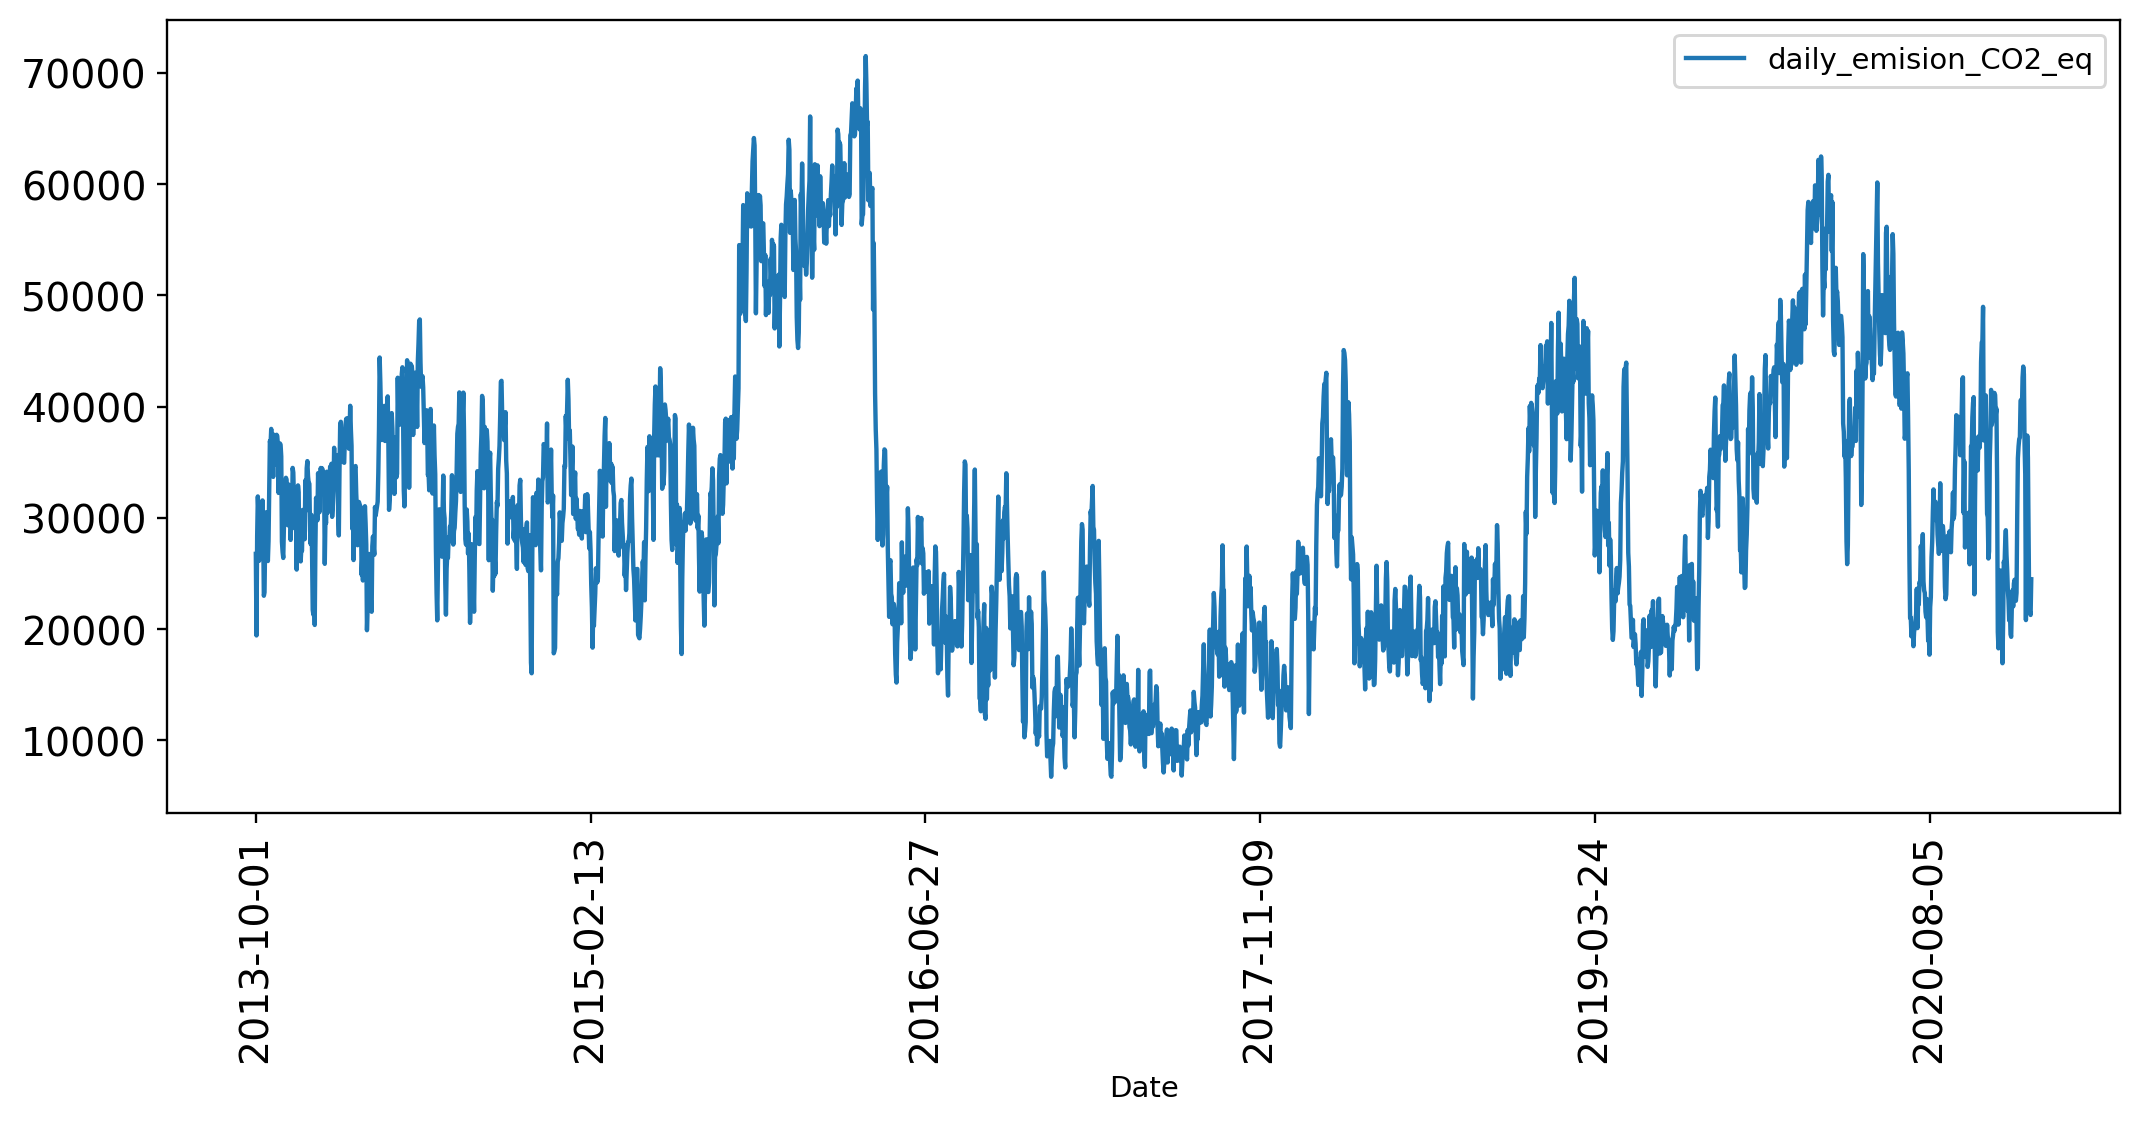

In [244]:
df_CO2_ts.plot(rot=90, figsize = (12, 5), fontsize = 13.5);

##### **3.1.1.2 Escalamiento de los datos**

Con el objetivo de que los modelos no se destabilicen por la escala de los valores de nuestra serie de tiempo, usaremos el StanrdScaler sobre todo el dataset.

In [245]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_CO2_ts['daily_emision_CO2_eq'] = scaler.fit_transform(df_CO2_ts['daily_emision_CO2_eq'].values.reshape(-1, 1))

In [246]:
df_CO2_ts['daily_emision_CO2_eq']

Date
2013-10-01   -0.282952
2013-10-02   -0.852378
2013-10-03   -0.159237
2013-10-04    0.117953
2013-10-05   -0.000277
                ...   
2020-12-31   -0.114523
2021-01-01   -0.688880
2021-01-02   -0.684074
2021-01-03   -0.709319
2021-01-04   -0.460062
Name: daily_emision_CO2_eq, Length: 2653, dtype: float64

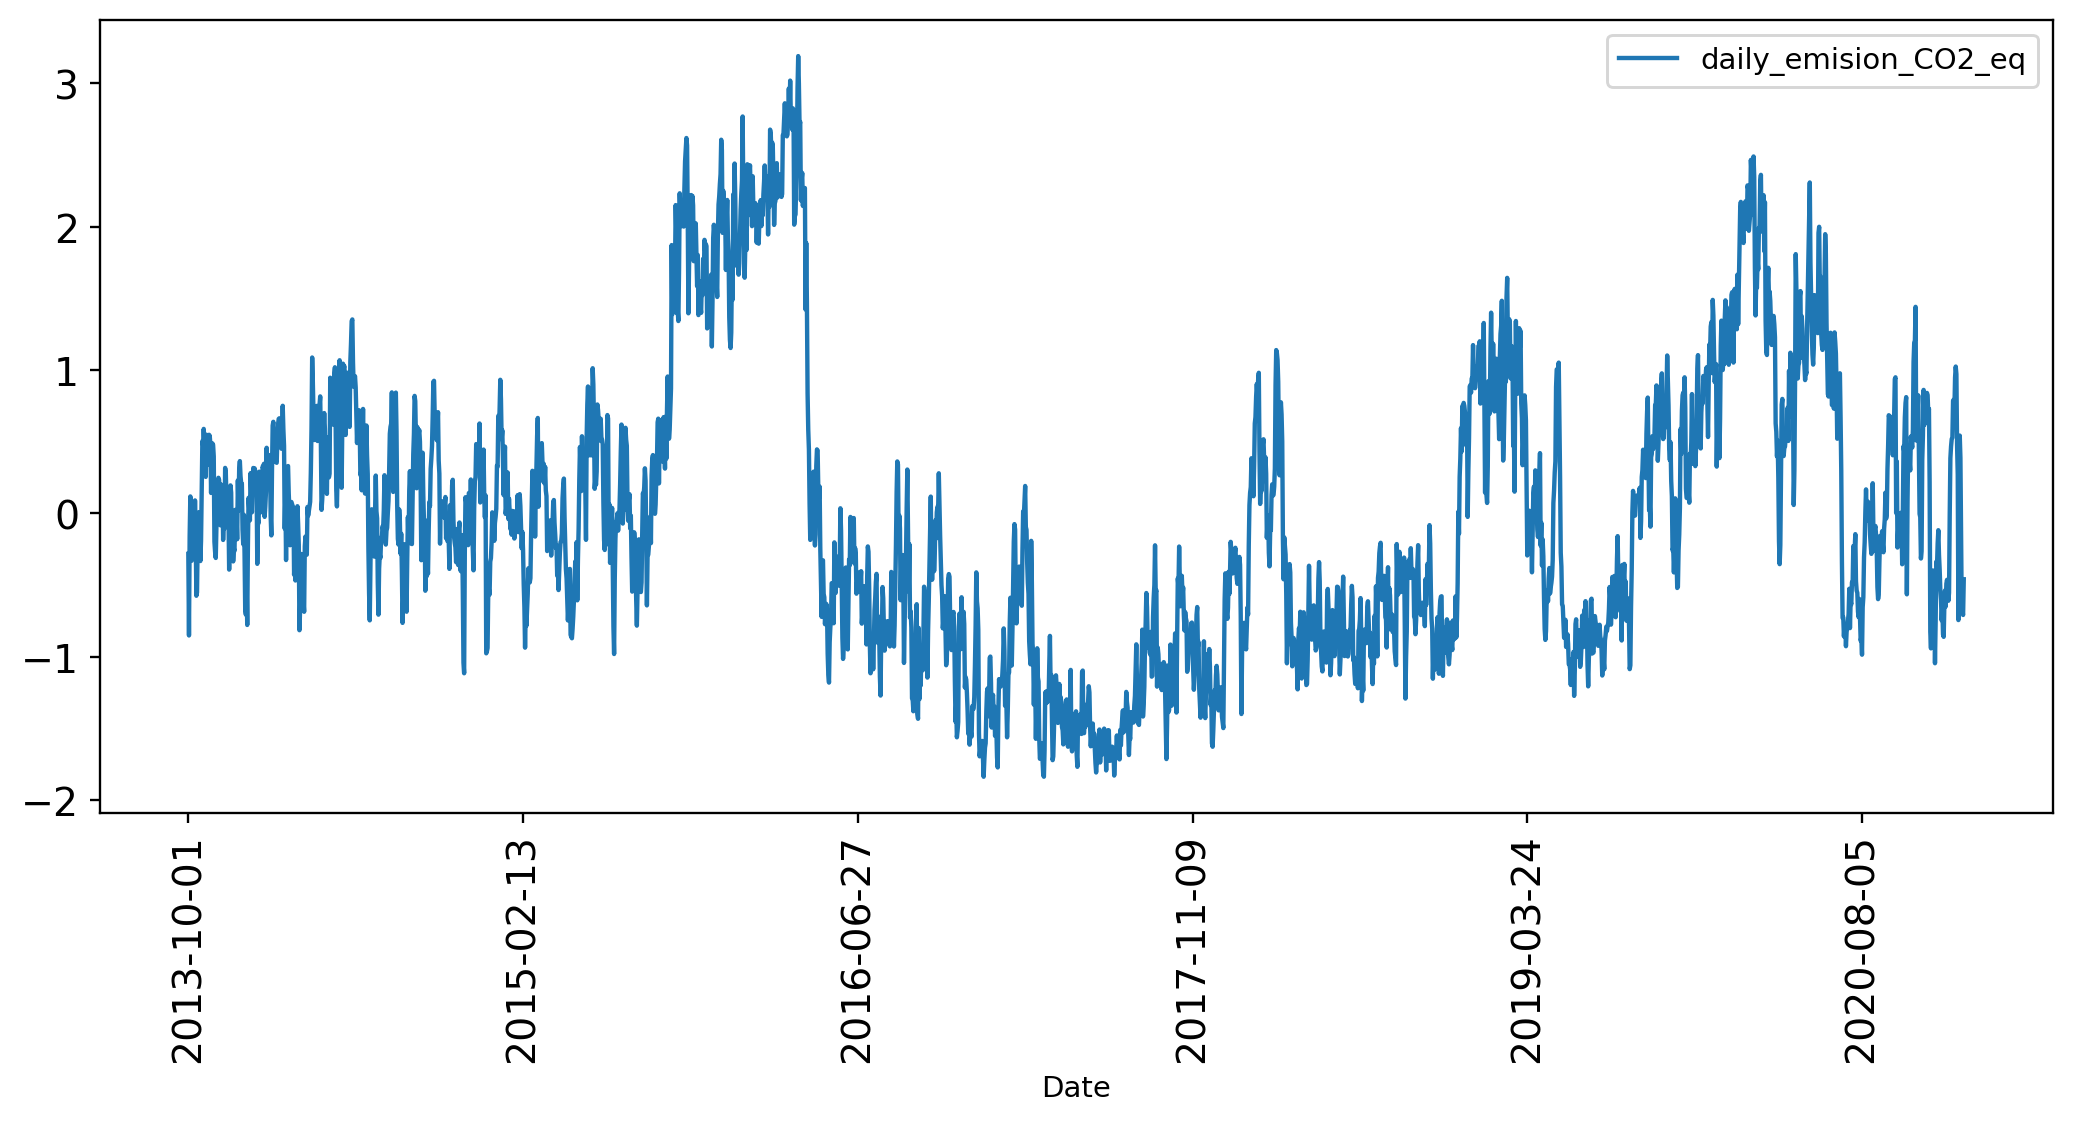

In [247]:
df_CO2_ts.plot(rot=90, figsize = (12, 5), fontsize = 13.5);

#### **3.1.2. Validación cruzada para series de tiempo**
---

In [248]:
data_train = df_CO2_ts['daily_emision_CO2_eq'].loc[:'2018-10-01']  # Primeros 5 años
data_test  = df_CO2_ts['daily_emision_CO2_eq'].loc['2018-10-02':]  # Últimos 2 años.

data_train.index[-1], data_test.index[0] # Fechas de inicio de ambos conjuntos.

('2018-10-01', '2018-10-02')

In [249]:
data_train.shape

(1827,)

In [250]:
# Creamos las ventanas y sus valores a predecir para entrenamiento y validación.
k=20
X_train, y_train = sliding_time(data_train.values, window_size=k) 

In [251]:
print(f"Número de ejemplos de entrenamiento: {X_train.shape[0]} (Ventana de tamaño {X_train.shape[1]})")
print(f"Número de valores a predecir: {y_train.shape[0]}")

Número de ejemplos de entrenamiento: 1807 (Ventana de tamaño 20)
Número de valores a predecir: 1807


In [252]:
# Creamos las ventanas y sus valores a predecir para entrenamiento y validación.
X_test, y_test = sliding_time(data_test.values, window_size=k) 

In [253]:
print(f"Número de ejemplos de entrenamiento: {X_test.shape[0]} (Ventana de tamaño {X_test.shape[1]})")
print(f"Número de valores a predecir: {y_test.shape[0]}")

Número de ejemplos de entrenamiento: 806 (Ventana de tamaño 20)
Número de valores a predecir: 806


In [254]:
pd.DataFrame(X_train)

0         1         2   ...        17        18        19
0    -0.282952 -0.852378 -0.159237  ... -0.111755 -0.333026 -0.192821
1    -0.852378 -0.159237  0.117953  ... -0.333026 -0.192821  0.139254
2    -0.159237  0.117953 -0.000277  ... -0.192821  0.139254  0.504397
3     0.117953 -0.000277 -0.331083  ...  0.139254  0.504397  0.476766
4    -0.000277 -0.331083 -0.233256  ...  0.504397  0.476766  0.589103
...        ...       ...       ...  ...       ...       ...       ...
1802 -0.963048 -1.013402 -1.058799  ... -1.002465 -0.824477 -0.349575
1803 -1.013402 -1.058799 -0.214309  ... -0.824477 -0.349575 -0.334957
1804 -1.058799 -0.214309 -0.447473  ... -0.349575 -0.334957 -0.363967
1805 -0.214309 -0.447473 -0.566862  ... -0.334957 -0.363967 -0.319148
1806 -0.447473 -0.566862 -0.525027  ... -0.363967 -0.319148 -0.451065

[1807 rows x 20 columns]

In [255]:
y_train

array([ 0.13925443,  0.50439663,  0.47676578, ..., -0.31914849,
       -0.45106473, -0.24339962])

#### **3.1.3. Partición de los datos de entrenamiento y pruebas**
---

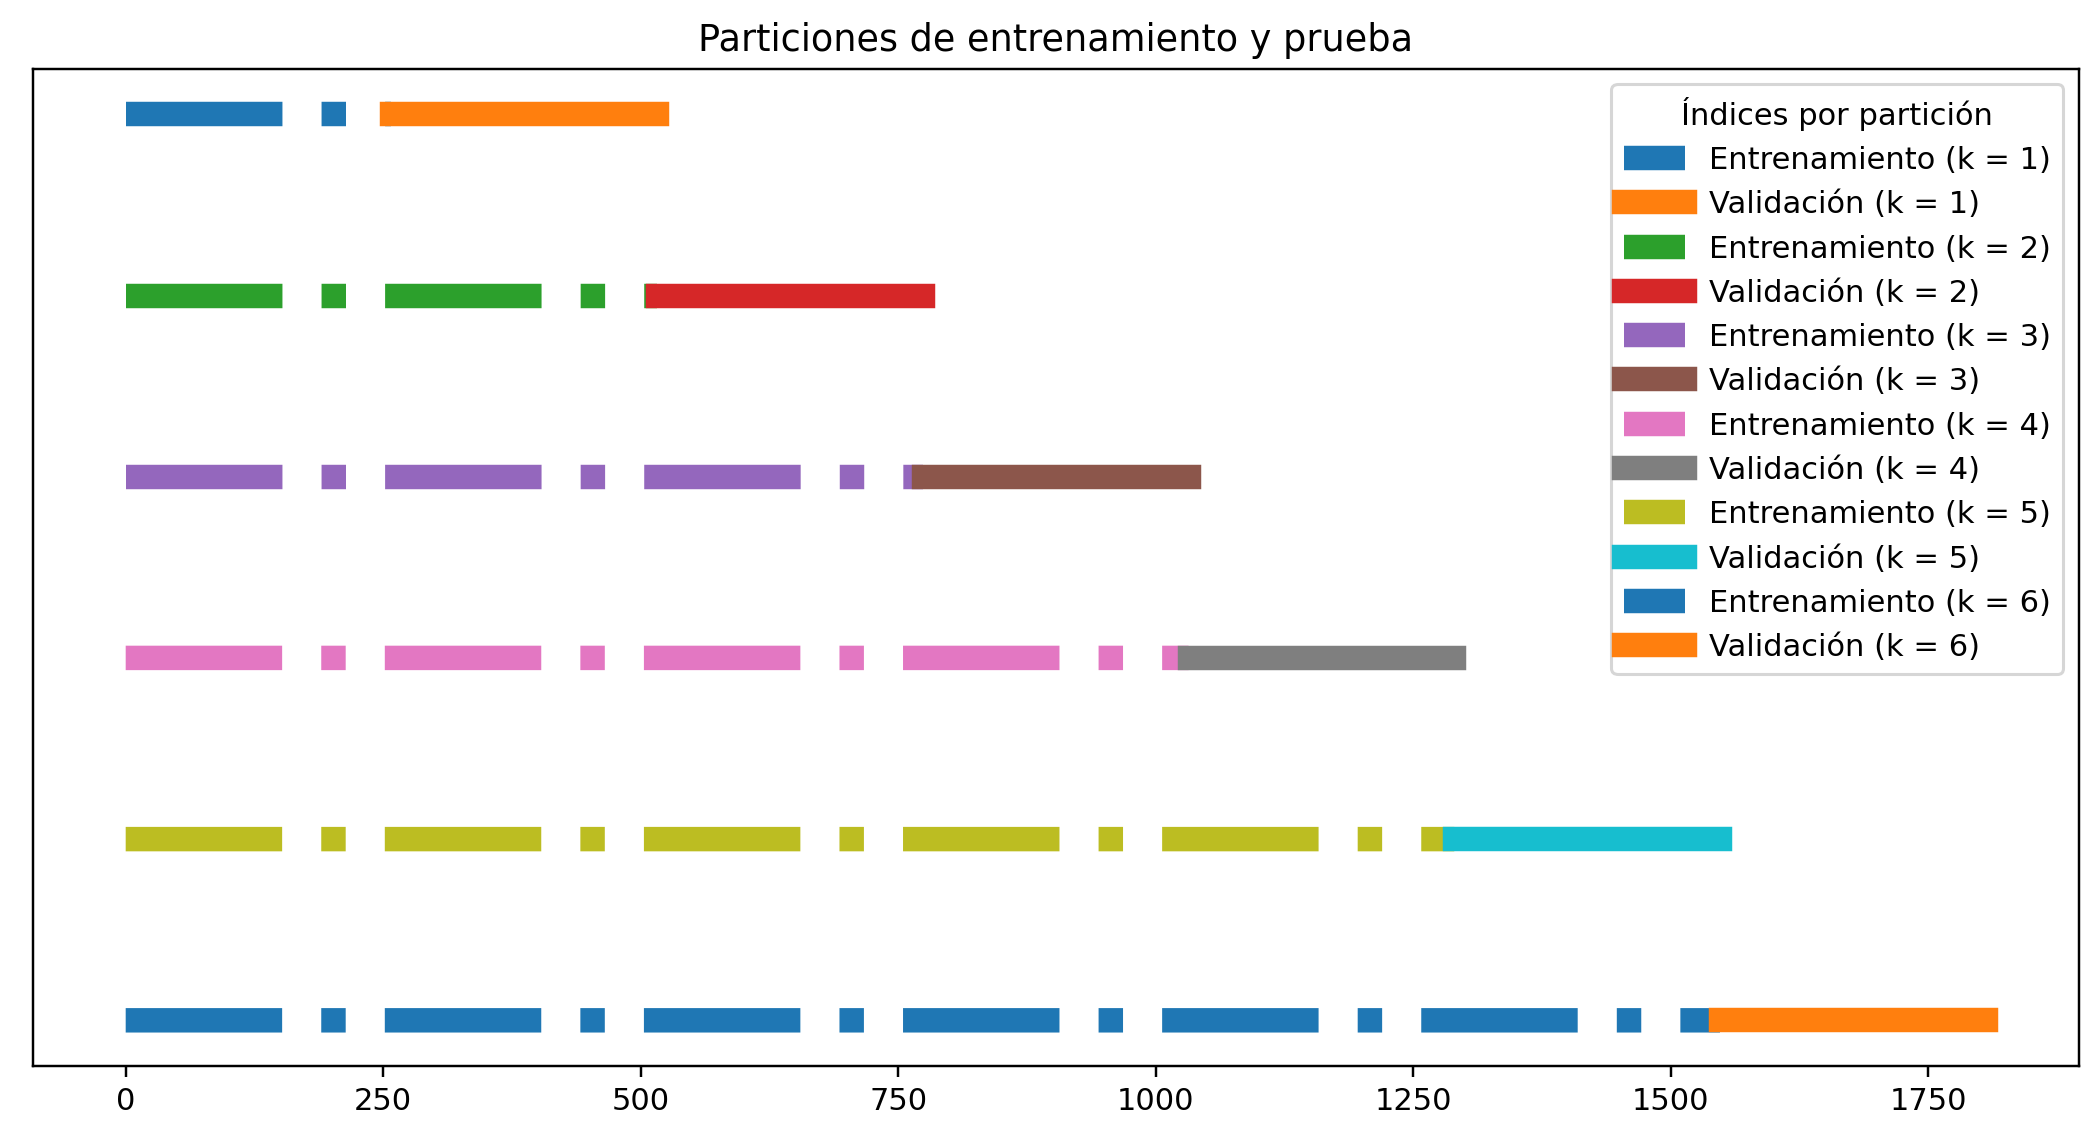

In [256]:

# Selección de los datos en series de tiempo
from sklearn.model_selection import TimeSeriesSplit

n_splits = 6

# La partición nos devuelve los indices de train y test.
tsp = TimeSeriesSplit(n_splits=n_splits)

i = 0
fig = plt.figure(figsize = (12,6), dpi = 110)
plt.set_cmap('Paired')

tsp_indexes = [(train_index, test_index) for (train_index, test_index) in tsp.split(X_train, y_train)]

for train_index, test_index in tsp_indexes:
  plt.plot(train_index, 
           np.full(len(train_index), 1-i*0.001),
           lw = 8, 
           ls= '-.', 
           label = f'Entrenamiento (k = {i + 1})')
  
  plt.plot(test_index, 
           np.full(len(test_index), 1-i*0.001), 
           lw = 8, 
           ls= '-', 
           label = f'Validación (k = {i + 1})')
  i+=1
fig.get_axes()[0].get_yaxis().set_visible(False)
plt.legend(ncol=1, title = 'Índices por partición', );
plt.title('Particiones de entrenamiento y prueba')
plt.show()

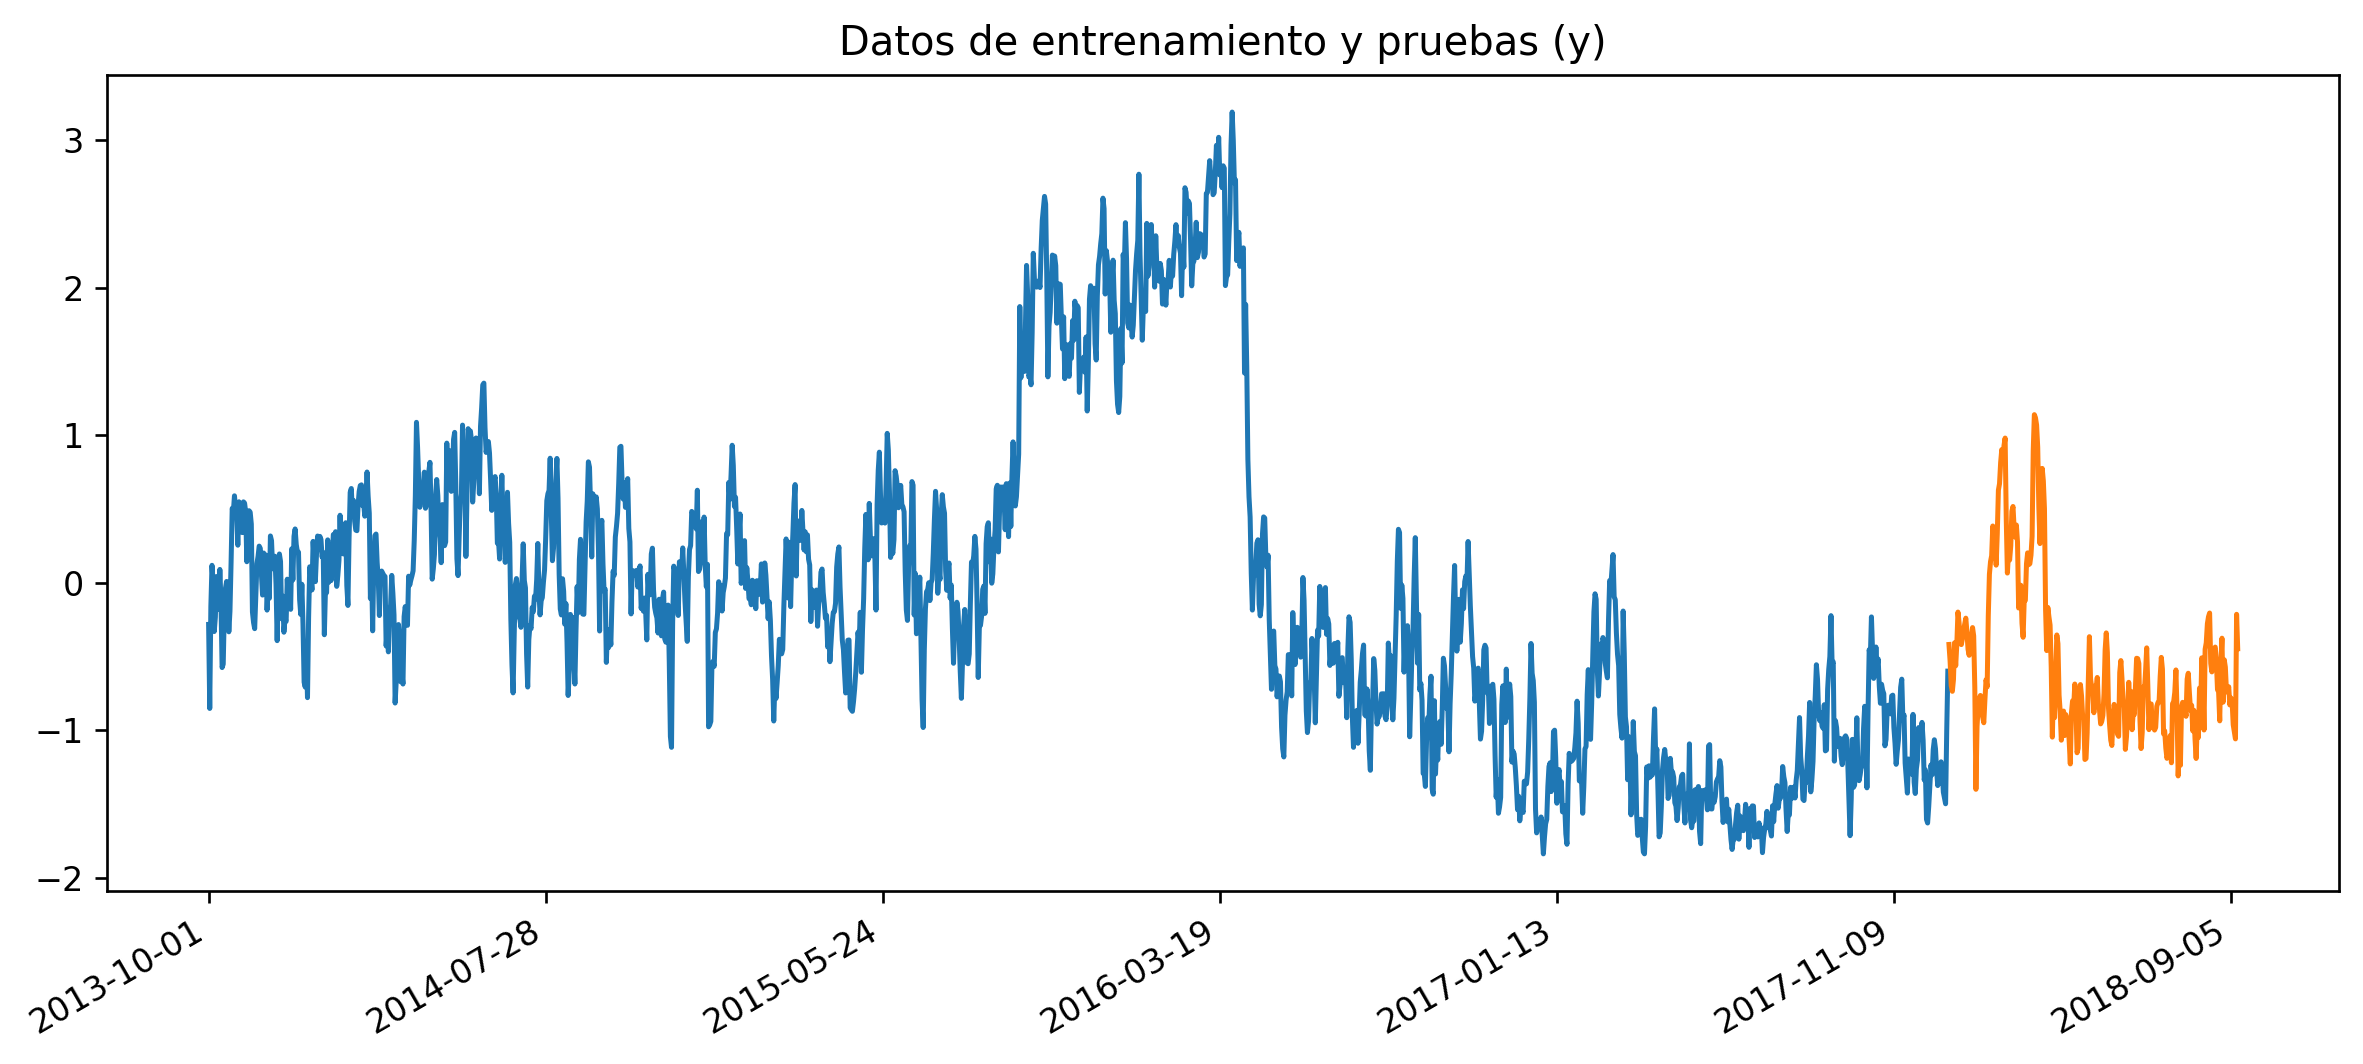

In [257]:
# Datos de prueba y entrenamiento con Matplotlib
train_index, test_index = tsp_indexes[-1]

fig = plt.figure(dpi = 120, figsize = (12, 5))
plt.plot(df_CO2_ts['daily_emision_CO2_eq'][train_index].index, df_CO2_ts['daily_emision_CO2_eq'][train_index].values, label = "Entrenamiento (y)")
plt.plot(df_CO2_ts['daily_emision_CO2_eq'][test_index].index, df_CO2_ts['daily_emision_CO2_eq'][test_index].values, label = "Prueba (y)")
plt.xticks(np.arange(0, 1900, 300))
plt.title('Datos de entrenamiento y pruebas (y)')
fig.autofmt_xdate()
plt.show()

#### **3.1.4. Regresion con Perceptrón Multicapa**
---

In [258]:
from sklearn.neural_network import MLPRegressor 

model = MLPRegressor(solver = 'lbfgs',
                   activation = 'relu',
                   hidden_layer_sizes=(120, 60, 30),
                   max_iter=200,                   
                   n_iter_no_change=50, 
                   validation_fraction=0.2,               
                   random_state=1234)
model.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(120, 60, 30), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=50, nesterovs_momentum=True,
             power_t=0.5, random_state=1234, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.2, verbose=False,
             warm_start=False)

In [259]:
# Métricas de rendimiento
# Error absoluto, cuadrado, y cuadrado logarítmico.
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error 

y_pred = model.predict(X_test)

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_pred):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_pred):.4f}")

Test Mean Squared Error: 	0.0828
Test Mean Absolute Error: 	0.2189


In [260]:
y_pred.shape

(806,)

In [261]:
y_test.shape

(806,)

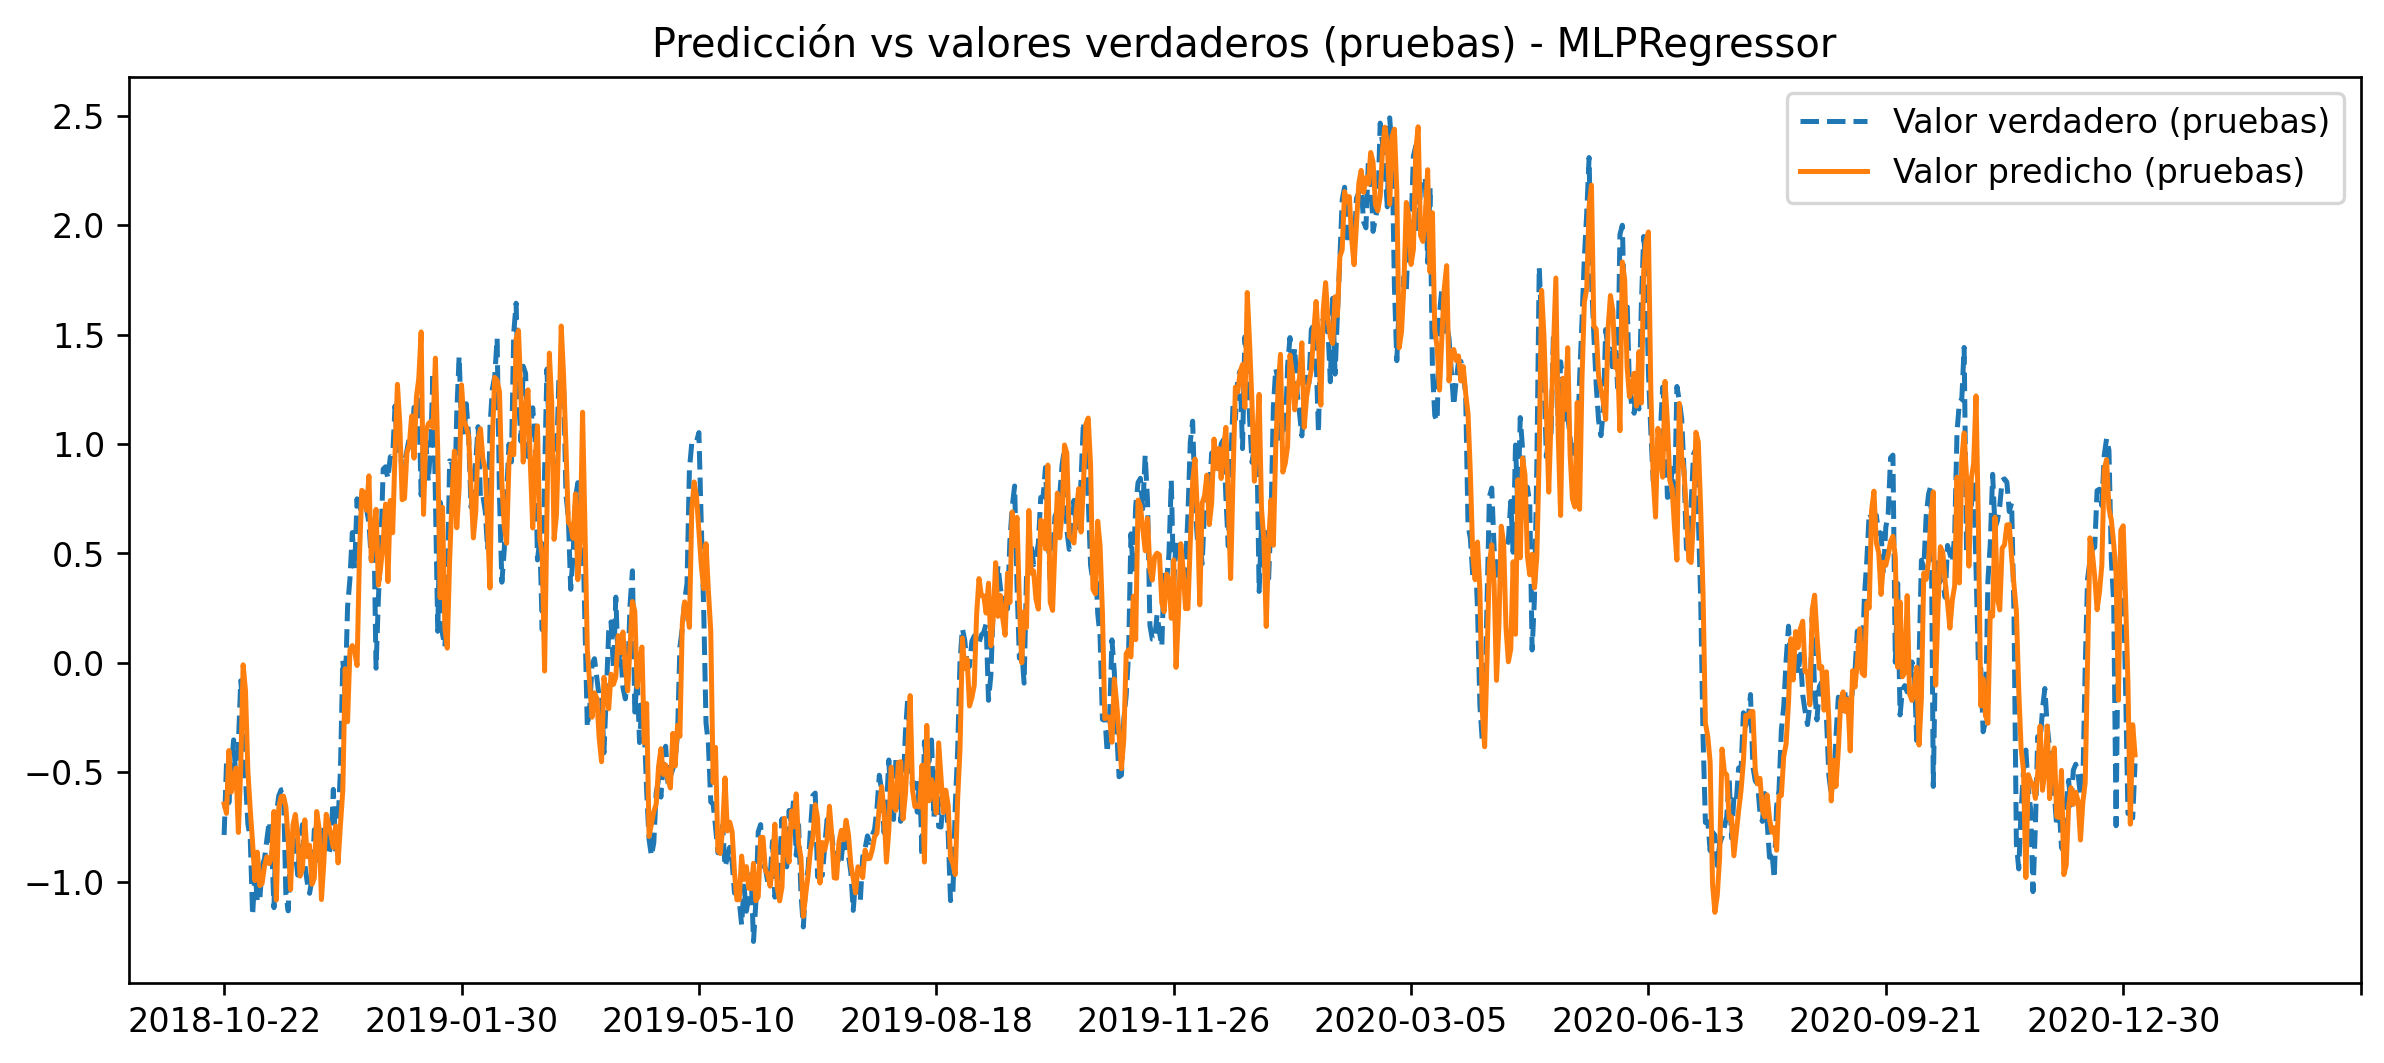

In [262]:
x = data_test.index[k:]

fig = plt.figure(dpi = 120, figsize = (12, 5))
plt.plot(x, y_test, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_pred, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas) - MLPRegressor")
plt.xticks(np.arange(0, 1000, 100))
plt.legend();

##### **3.1.4.1 Busqueda de hiperparametros**
---

In [263]:
model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (120, 60, 30),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 50,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1234,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.2,
 'verbose': False,
 'warm_start': False}

In [264]:
params_MLP = {    
      'hidden_layer_sizes' : [(240,120,60,20), (120, 80,40,20), (80,40,20,10)], # Algunas arquitecturas propuestas.
      'activation' : ['tanh', 'relu'],
      'solver': ['adam']
 }

In [265]:
from sklearn.model_selection import GridSearchCV
tsp = TimeSeriesSplit(n_splits = 3)

gsearch = GridSearchCV(estimator = MLPRegressor(random_state=1234,
                                                max_iter= 2000,
                                                n_iter_no_change=50, 
                                                validation_fraction=0.2), 
                        cv = tsp,
                        param_grid = params_MLP, 
                        verbose = 3)

gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam, score=0.475, total=   8.4s
[CV] activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV]  activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam, score=0.235, total=  24.4s
[CV] activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.7s remaining:    0.0s


[CV]  activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam, score=0.746, total=  41.1s
[CV] activation=tanh, hidden_layer_sizes=(120, 80, 40, 20), solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(120, 80, 40, 20), solver=adam, score=0.423, total=   7.9s
[CV] activation=tanh, hidden_layer_sizes=(120, 80, 40, 20), solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(120, 80, 40, 20), solver=adam, score=0.449, total=  24.6s
[CV] activation=tanh, hidden_layer_sizes=(120, 80, 40, 20), solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(120, 80, 40, 20), solver=adam, score=0.754, total=  33.5s
[CV] activation=tanh, hidden_layer_sizes=(80, 40, 20, 10), solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(80, 40, 20, 10), solver=adam, score=0.400, total=   5.9s
[CV] activation=tanh, hidden_layer_sizes=(80, 40, 20, 10), solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(80, 40, 20, 10), solver=adam, score=0.272, total=  19.1s
[CV] activation=tanh, hidden_lay

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=2000, momentum=0.9,
                                    n_iter_no_change=50,
                                    ne...
                                    random_state=1234, shuffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.2, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
        

In [266]:
# Los mejores 10 modelos con respecto a su mean_test_score.
best_MLP_models = pd.DataFrame(gsearch.cv_results_).nlargest(10, 'mean_test_score')
best_MLP_models

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
3       8.317627      4.385190  ...        0.368458                1
1      21.985681     10.618679  ...        0.150386                2
0      24.586655     13.355970  ...        0.208855                3
2      19.243336     10.940507  ...        0.207677                4
5       7.266600      4.172413  ...        0.541420                5
4       6.356930      3.351717  ...        0.801593                6

[6 rows x 14 columns]

In [267]:
# Últimos valores de entrenamiento a usar para la predicción.
X_last = X_test[:1]

# Listas con los datos en y, empezando desde el primer valor de pruebas.
y_last = [] 
y_forward = []

for i in range(len(X_test)):  
  # Valores predichos a partir de datos reales (X_test)
  y_pred_forward = gsearch.predict(X_test[i: i + 1]) 
  y_forward.append(y_pred_forward[0])  

  # Valores predichos a partir de datos predichos y retroalimentados.
  y_pred_last = gsearch.predict(X_last)  # Se predice el valor siguiente a partir de datos predichos previamente.
  y_last.append(y_pred_last[0])          # Guardamos el valor predicho.

  # Creación de la nueva ventana añadiendo la última predicción.
  X_last = np.roll(X_last, -1)           # Desplazamos todos los valores hacia la izquierda con np.roll
  X_last[0,-1] = y_pred_last             # Guardamos el valor predicho en la última posición del arreglo.

#Gráficamos las 2 predicciones distintas en comparación con los valores reales.

test_date_index = data_test.index[k:]
plot_prediction_new(gsearch.best_params_, 
                (y_test, y_forward),
                 test_date_index)

In [268]:
df_one_day_predictions = pd.DataFrame()
df_one_day_predictions['y_test'] = y_test
df_one_day_predictions['y_MLP'] = y_forward

#### **3.1.5 Regresión con RandomForest**

In [269]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [270]:
y_pred = rf.predict(X_test)

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_pred):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_pred):.4f}")

Test Mean Squared Error: 	0.0692
Test Mean Absolute Error: 	0.2018


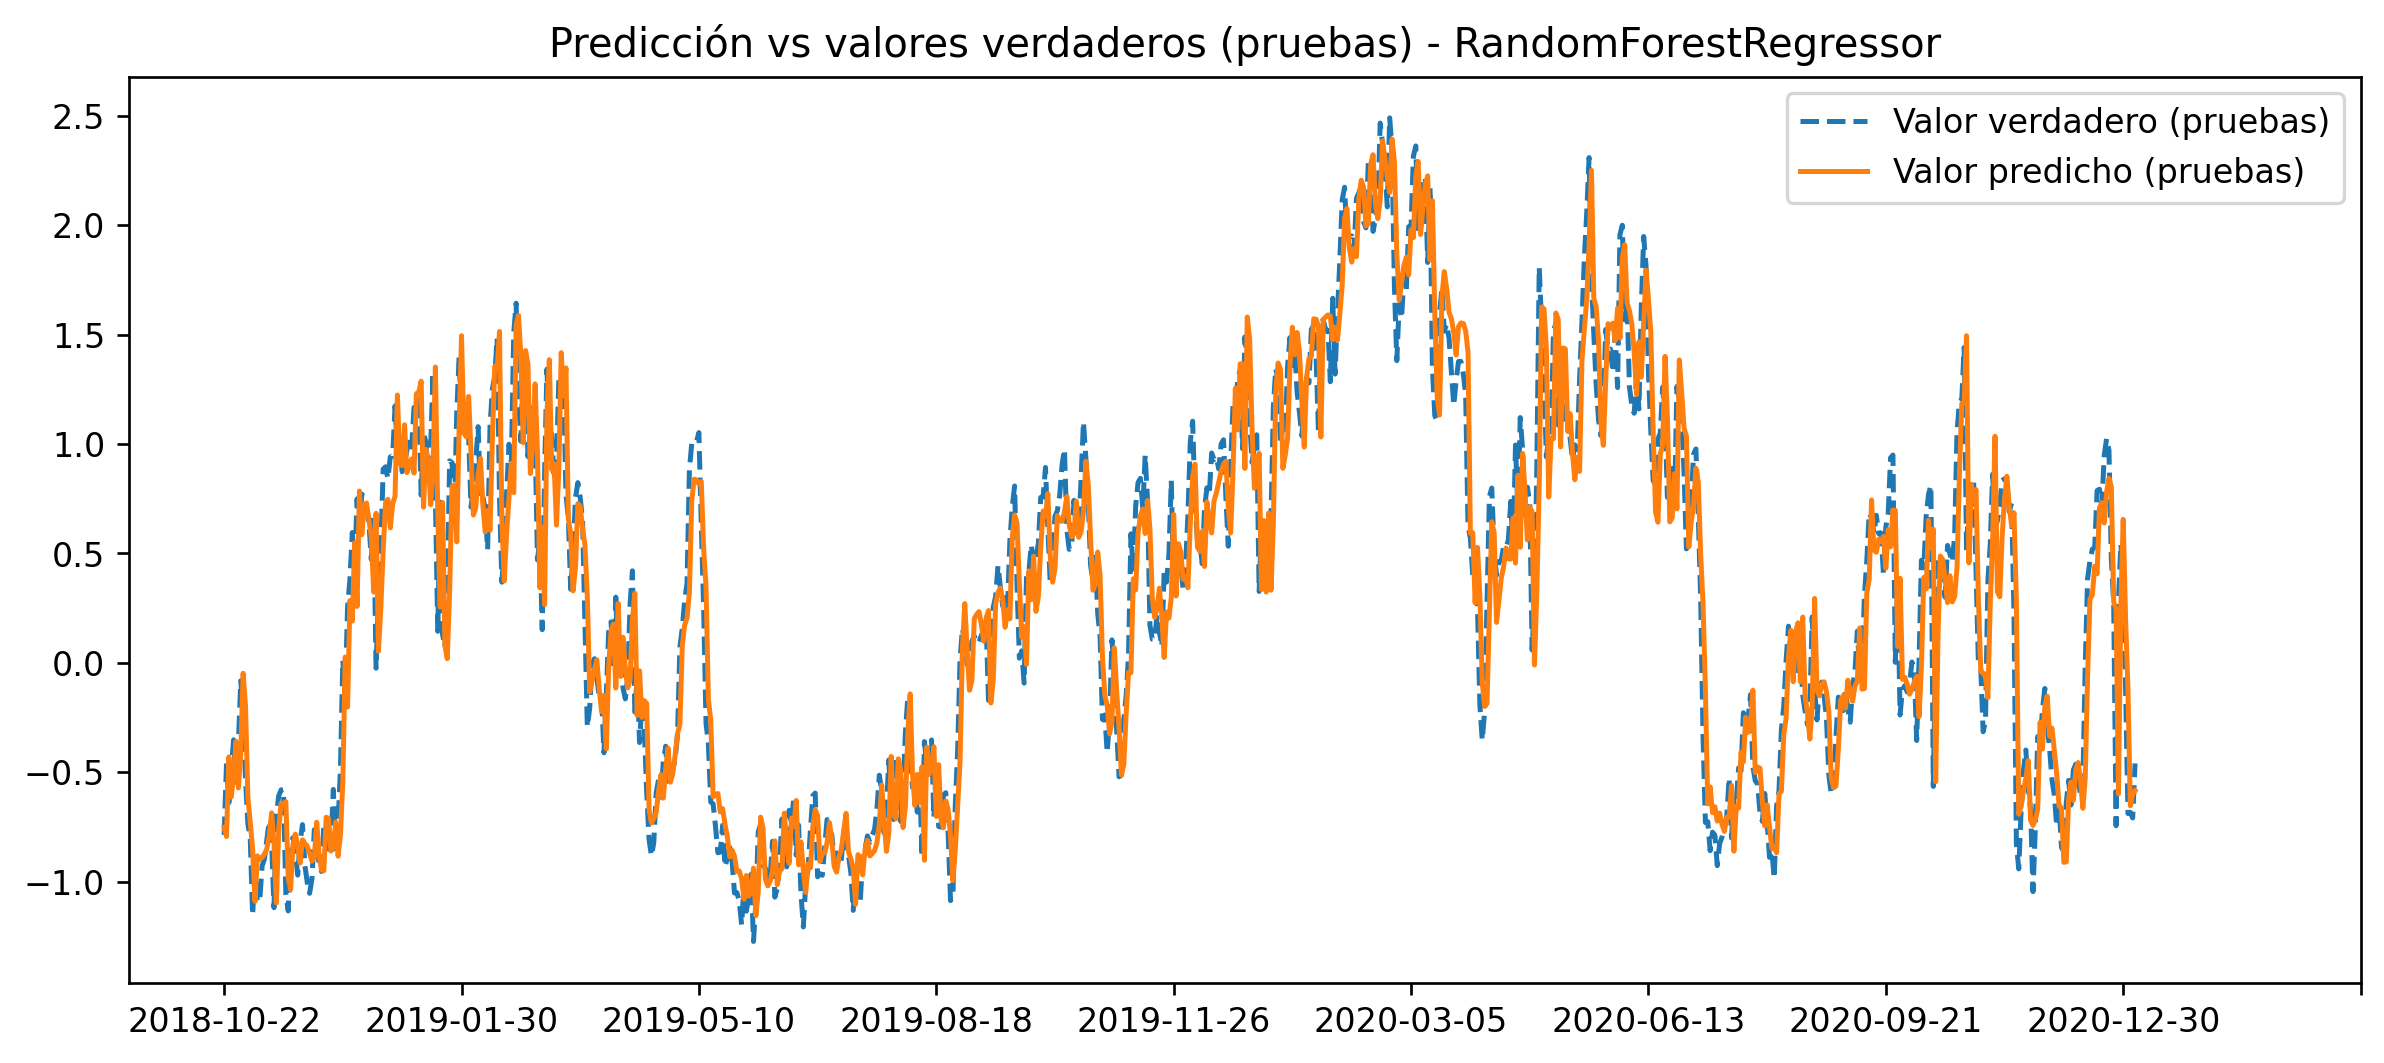

In [271]:
x = data_test.index[k:]

fig = plt.figure(dpi = 120, figsize = (12, 5))
plt.plot(x, y_test, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_pred, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas) - RandomForestRegressor")
plt.xticks(np.arange(0, 1000, 100))
plt.legend();

In [272]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

##### **3.1.5.1 Busqueda de hiperparametros**
---

In [273]:
params_RFR = { 
    'n_estimators': [3,6,12,24,52,104],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,100,1000]
    #'min_samples_leaf': [1,2],
    #'min_samples_split': [2,3]
    }

In [274]:
tsp = TimeSeriesSplit(n_splits = 3)

gsearch = GridSearchCV(estimator = RandomForestRegressor(random_state = 42), 
                        cv = tsp,
                        param_grid = params_RFR, 
                        verbose = 3)

gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] max_depth=10, max_features=auto, n_estimators=3 .................
[CV]  max_depth=10, max_features=auto, n_estimators=3, score=0.655, total=   0.0s
[CV] max_depth=10, max_features=auto, n_estimators=3 .................
[CV]  max_depth=10, max_features=auto, n_estimators=3, score=-0.476, total=   0.0s
[CV] max_depth=10, max_features=auto, n_estimators=3 .................
[CV]  max_depth=10, max_features=auto, n_estimators=3, score=0.812, total=   0.0s
[CV] max_depth=10, max_features=auto, n_estimators=6 .................
[CV]  max_depth=10, max_features=auto, n_estimators=6, score=0.677, total=   0.0s
[CV] max_depth=10, max_features=auto, n_estimators=6 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=6, score=-0.436, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=6 .................
[CV]  max_depth=10, max_features=auto, n_estimators=6, score=0.828, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=12 ................
[CV]  max_depth=10, max_features=auto, n_estimators=12, score=0.646, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=12 ................
[CV]  max_depth=10, max_features=auto, n_estimators=12, score=-0.517, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=12 ................
[CV]  max_depth=10, max_features=auto, n_estimators=12, score=0.835, total=   0.2s
[CV] max_depth=10, max_features=auto, n_estimators=24 ................
[CV]  max_depth=10, max_features=auto, n_estimators=24, score=0.600, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=24 ................
[CV]  max_depth=10, max_features=auto, n_estimators=24, score=-0.382, total=

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:   32.0s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose

In [275]:
# Los mejores 10 modelos con respecto a su mean_test_score.
best_RFR_models = pd.DataFrame(gsearch.cv_results_).nlargest(10, 'mean_test_score')
best_RFR_models

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
22       0.569946      0.213456  ...        0.463047                1
40       0.545427      0.227493  ...        0.463047                1
4        0.483088      0.176321  ...        0.461565                3
23       1.075372      0.458082  ...        0.492930                4
41       1.077451      0.460127  ...        0.492930                4
5        0.931845      0.358666  ...        0.490658                6
1        0.063318      0.029433  ...        0.563615                7
19       0.070633      0.030302  ...        0.563786                8
37       0.066500      0.027760  ...        0.563786                8
3        0.227115      0.084412  ...        0.529213               10

[10 rows x 14 columns]

In [276]:
X_last = X_test[:1]

# Listas con los datos en y, empezando desde el primer valor de pruebas.
y_last = [] 
y_forward = []

for i in range(len(X_test)):  
  # Valores predichos a partir de datos reales (X_test)
  y_pred_forward = gsearch.predict(X_test[i: i + 1]) 
  y_forward.append(y_pred_forward[0])  

  # Valores predichos a partir de datos predichos y retroalimentados.
  y_pred_last = gsearch.predict(X_last)  # Se predice el valor siguiente a partir de datos predichos previamente.
  y_last.append(y_pred_last[0])          # Guardamos el valor predicho.

  # Creación de la nueva ventana añadiendo la última predicción.
  X_last = np.roll(X_last, -1)           # Desplazamos todos los valores hacia la izquierda con np.roll
  X_last[0,-1] = y_pred_last             # Guardamos el valor predicho en la última posición del arreglo.

#Gráficamos las 2 predicciones distintas en comparación con los valores reales.

test_date_index = data_test.index[k:]
plot_prediction_new(gsearch.best_params_, 
                (y_test, y_forward),
                 test_date_index)
df_one_day_predictions['y_RFR'] = y_forward

#### **3.1.6. Regresion con Support Vector Machines**

In [277]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_rbf.fit(X_train, y_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [278]:
y_pred = svr_rbf.predict(X_test)

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_pred):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_pred):.4f}")

Test Mean Squared Error: 	0.1343
Test Mean Absolute Error: 	0.2795


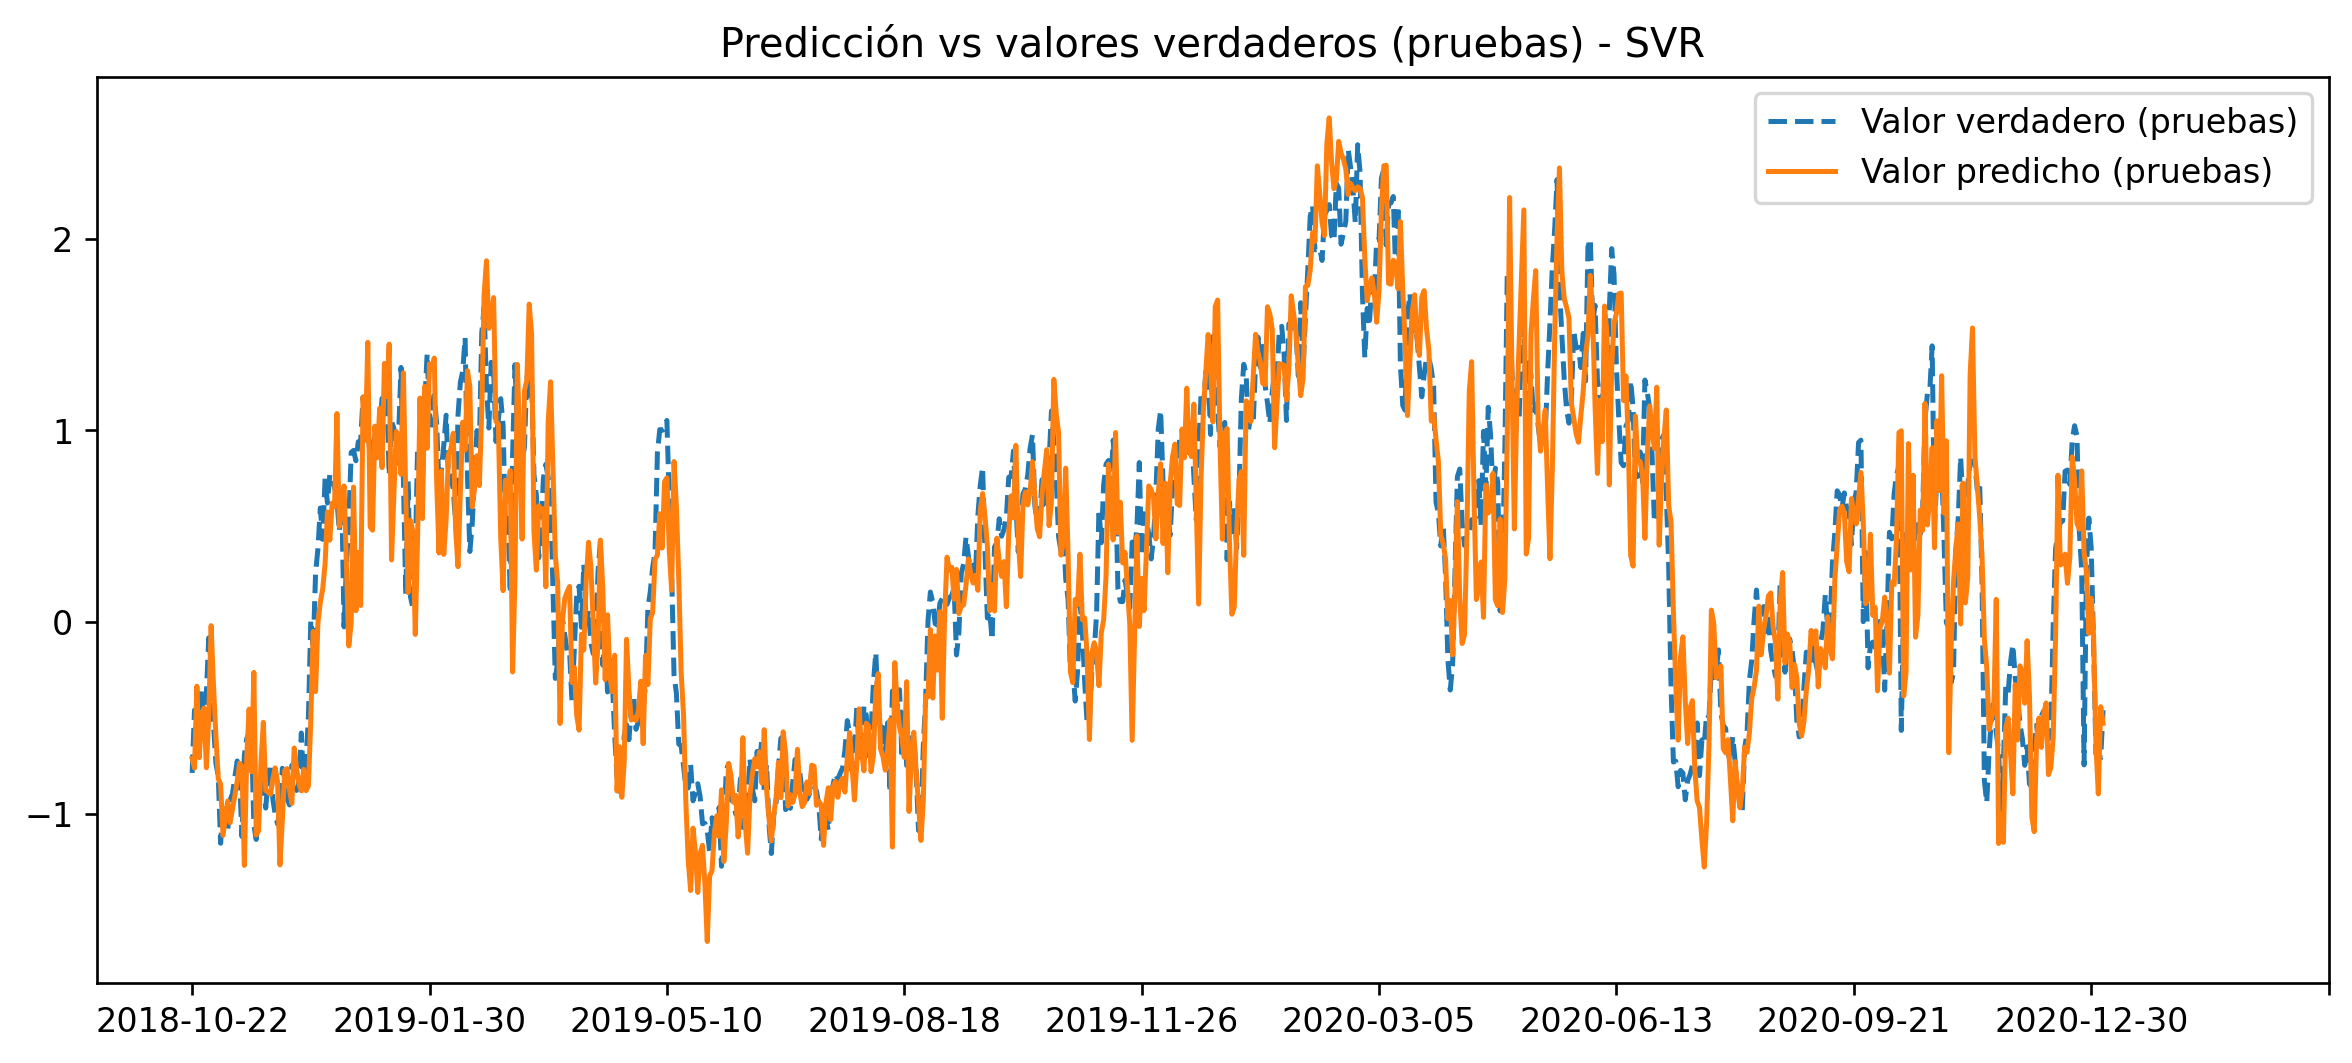

In [279]:
x = data_test.index[k:]

fig = plt.figure(dpi = 120, figsize = (12, 5))
plt.plot(x, y_test, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_pred, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas) - SVR")
plt.xticks(np.arange(0, 1000, 100))
plt.legend();

##### **3.1.6.1 Busqueda de hiperparametros**
---

In [280]:
svr_rbf.get_params()

{'C': 100,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [281]:
params_SVR = {'C': [1, 10, 100, 1000],
          'kernel': ['rbf','poly'],
          'gamma': [0.01,0.001, 0.0001],
          'degree': [2,3,4,5,6,8],
          'epsilon': [0.1,0.2]}

In [282]:
tsp = TimeSeriesSplit(n_splits = 3)

gsearch = GridSearchCV(estimator = SVR(), 
                        cv = tsp,
                        param_grid = params_SVR, 
                        verbose = 3)

gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf ..............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.737, total=   0.1s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf ..............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf, score=-1.062, total=   0.1s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.871, total=   0.2s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly, score=0.666, total=   0.0s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly, score=-8.232, total=   0.1s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly, score=-4.412, total=   0.1s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.630, total=   0.0s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.403, total=   0.1s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf

[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:  2.9min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000], 'degree': [2, 3, 4, 5, 6, 8],
                         'epsilon': [0.1, 0.2], 'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [283]:
# Los mejores 10 modelos con respecto a su mean_test_score.
best_SVM_models = pd.DataFrame(gsearch.cv_results_).nlargest(10, 'mean_test_score')
best_SVM_models

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
148       0.074024      0.048677  ...        0.054431                1
160       0.073580      0.050249  ...        0.054431                1
172       0.073499      0.048784  ...        0.054431                1
184       0.073408      0.050163  ...        0.054431                1
196       0.077195      0.058774  ...        0.054431                1
208       0.074602      0.049516  ...        0.054431                1
220       0.126165      0.086308  ...        0.088949                7
232       0.127033      0.097539  ...        0.088949                7
244       0.129130      0.095109  ...        0.088949                7
256       0.117458      0.082695  ...        0.088949                7

[10 rows x 16 columns]

In [284]:
X_last = X_test[:1]

# Listas con los datos en y, empezando desde el primer valor de pruebas.
y_last = [] 
y_forward = []

for i in range(len(X_test)):  
  # Valores predichos a partir de datos reales (X_test)
  y_pred_forward = gsearch.predict(X_test[i: i + 1]) 
  y_forward.append(y_pred_forward[0])  

  # Valores predichos a partir de datos predichos y retroalimentados.
  y_pred_last = gsearch.predict(X_last)  # Se predice el valor siguiente a partir de datos predichos previamente.
  y_last.append(y_pred_last[0])          # Guardamos el valor predicho.

  # Creación de la nueva ventana añadiendo la última predicción.
  X_last = np.roll(X_last, -1)           # Desplazamos todos los valores hacia la izquierda con np.roll
  X_last[0,-1] = y_pred_last             # Guardamos el valor predicho en la última posición del arreglo.

#Gráficamos las 2 predicciones distintas en comparación con los valores reales.

test_date_index = data_test.index[k:]
plot_prediction_new(gsearch.best_params_, 
                (y_test, y_forward),
                 test_date_index)
df_one_day_predictions['y_SVM'] = y_forward

#### **3.1.7 Regresión con XGBoost**
---

In [285]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, objective='reg:squarederror')
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)

In [286]:
y_pred = xgb.predict(X_test)

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_pred):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_pred):.4f}")

Test Mean Squared Error: 	0.0768
Test Mean Absolute Error: 	0.2141


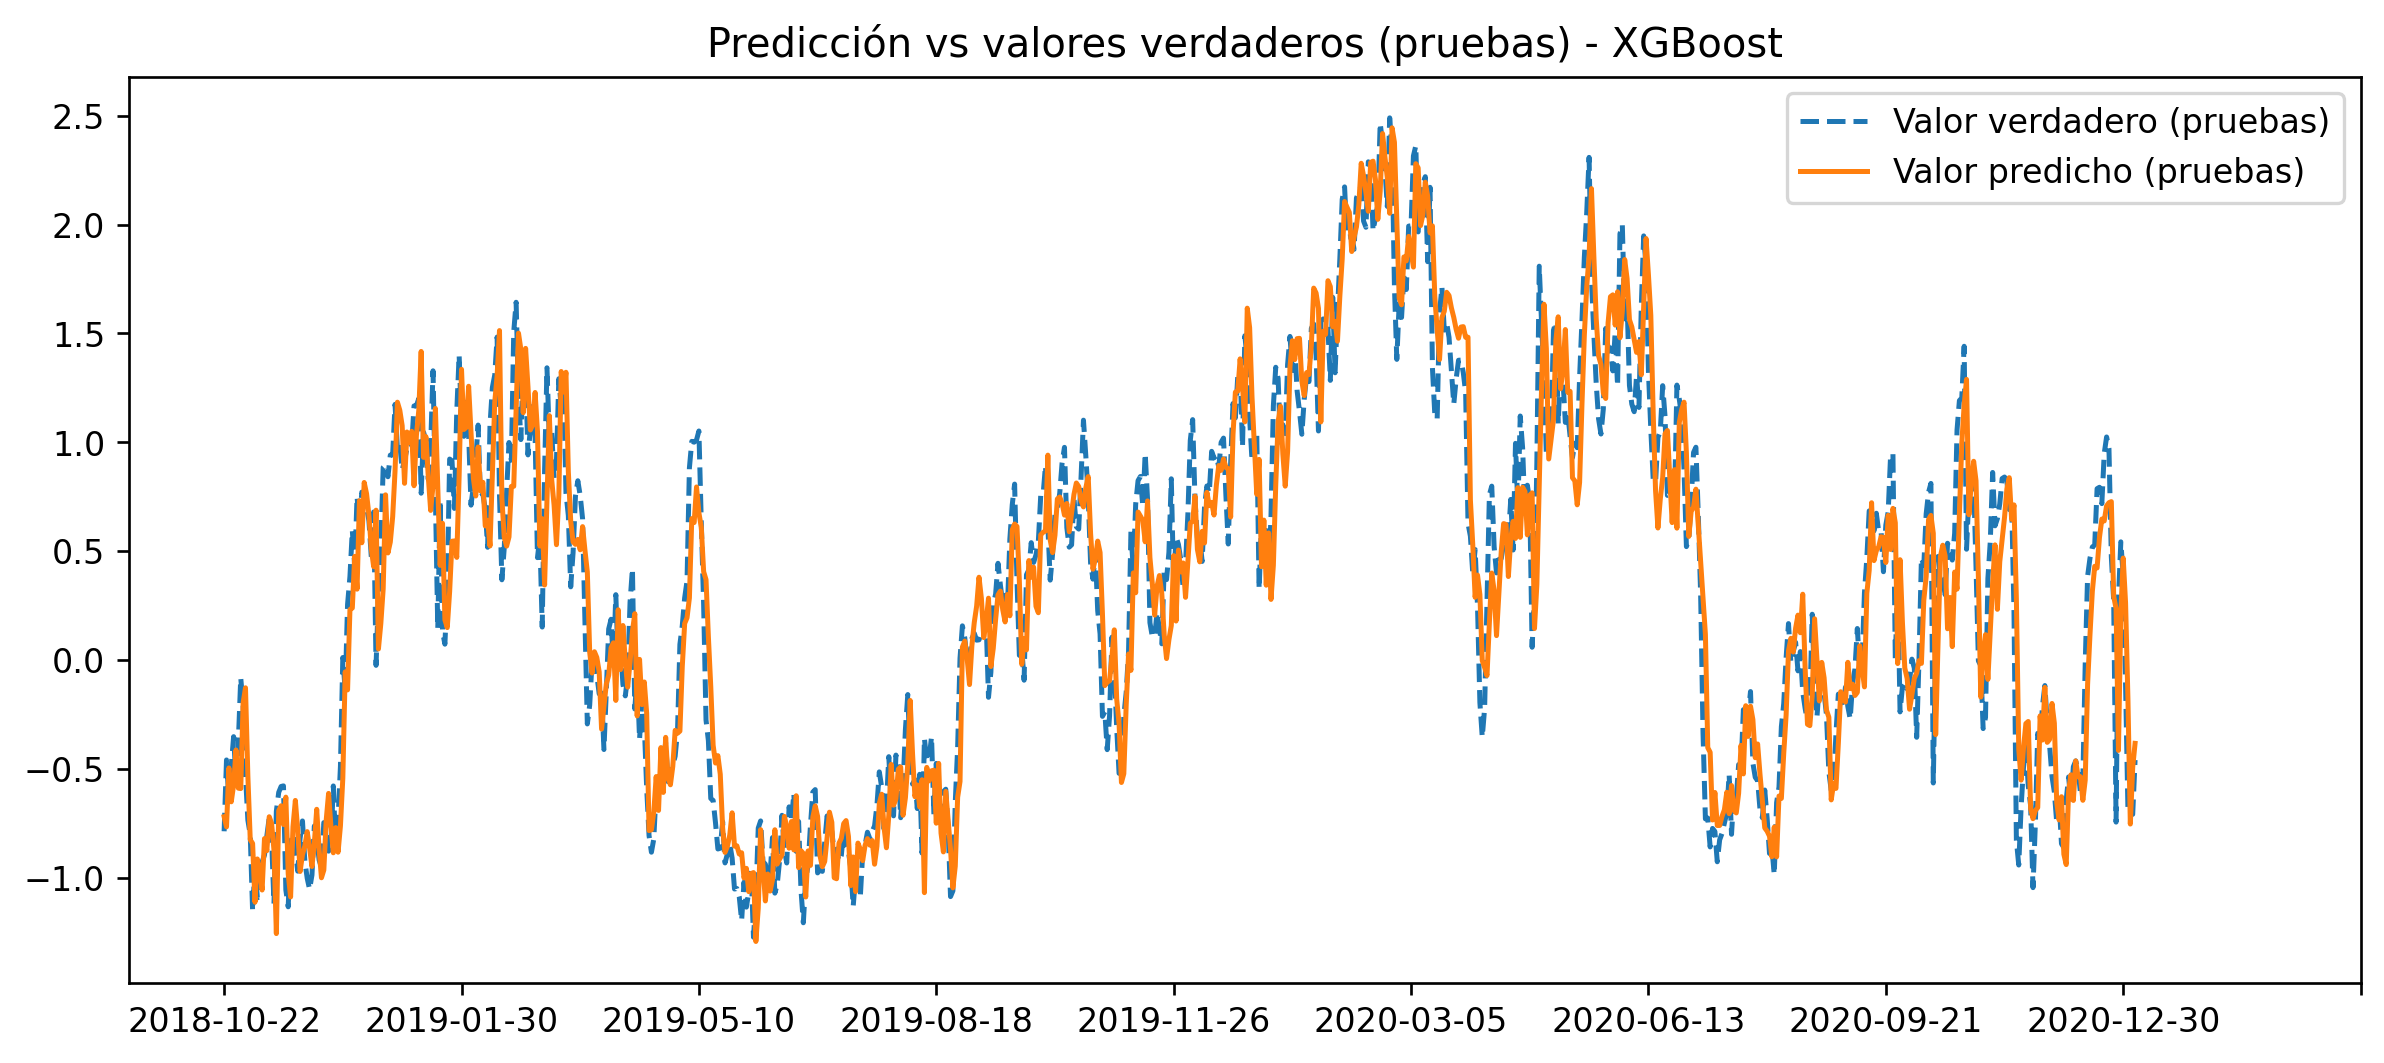

In [287]:
x = data_test.index[k:]

fig = plt.figure(dpi = 120, figsize = (12, 5))
plt.plot(x, y_test, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_pred, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas) - XGBoost")
plt.xticks(np.arange(0, 1000, 100))
plt.legend();

##### **3.1.7.1 Busqueda de hiperparametros**
---

In [288]:
params_XGB = {'n_estimators': [6,12,24,52,104,500,1000],
          'max_depth': [10,100,1000,2000],
          'reg_alpha': [0.1,0.2]}

In [289]:
tsp = TimeSeriesSplit(n_splits = 3)

gsearch = GridSearchCV(estimator = XGBRegressor(objective='reg:squarederror'), 
                        cv = tsp,
                        param_grid = params_XGB, 
                        verbose = 3)

gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] max_depth=10, n_estimators=6, reg_alpha=0.1 .....................
[CV]  max_depth=10, n_estimators=6, reg_alpha=0.1, score=0.174, total=   0.0s
[CV] max_depth=10, n_estimators=6, reg_alpha=0.1 .....................
[CV]  max_depth=10, n_estimators=6, reg_alpha=0.1, score=-3.755, total=   0.1s
[CV] max_depth=10, n_estimators=6, reg_alpha=0.1 .....................
[CV]  max_depth=10, n_estimators=6, reg_alpha=0.1, score=-0.934, total=   0.0s
[CV] max_depth=10, n_estimators=6, reg_alpha=0.2 .....................
[CV]  max_depth=10, n_estimators=6, reg_alpha=0.2, score=0.075, total=   0.0s
[CV] max_depth=10, n_estimators=6, reg_alpha=0.2 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=10, n_estimators=6, reg_alpha=0.2, score=-3.954, total=   0.0s
[CV] max_depth=10, n_estimators=6, reg_alpha=0.2 .....................
[CV]  max_depth=10, n_estimators=6, reg_alpha=0.2, score=-0.929, total=   0.0s
[CV] max_depth=10, n_estimators=12, reg_alpha=0.1 ....................
[CV]  max_depth=10, n_estimators=12, reg_alpha=0.1, score=0.345, total=   0.0s
[CV] max_depth=10, n_estimators=12, reg_alpha=0.1 ....................
[CV]  max_depth=10, n_estimators=12, reg_alpha=0.1, score=-2.988, total=   0.1s
[CV] max_depth=10, n_estimators=12, reg_alpha=0.1 ....................
[CV]  max_depth=10, n_estimators=12, reg_alpha=0.1, score=0.305, total=   0.1s
[CV] max_depth=10, n_estimators=12, reg_alpha=0.2 ....................
[CV]  max_depth=10, n_estimators=12, reg_alpha=0.2, score=0.196, total=   0.0s
[CV] max_depth=10, n_estimators=12, reg_alpha=0.2 ....................
[CV]  max_depth=10, n_estimators=12, reg_alpha=0.2, score=-2.979, total=   0.1s
[CV] max_depth=10, 

[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:  1.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [10, 100, 1000, 2000],
     

In [290]:
# Los mejores 10 modelos con respecto a su mean_test_score.
best_XGB_models = pd.DataFrame(gsearch.cv_results_).nlargest(10, 'mean_test_score')
best_XGB_models

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
24       1.418439      0.728636  ...        1.375511                1
26       1.689761      0.809654  ...        1.375511                1
38       1.430194      0.744880  ...        1.375511                1
40       1.675473      0.836983  ...        1.375511                1
52       1.420837      0.734887  ...        1.375511                1
54       1.666411      0.831126  ...        1.375511                1
22       0.805286      0.396865  ...        1.376007                7
36       0.801296      0.394801  ...        1.376007                7
50       0.797385      0.383494  ...        1.376007                7
10       0.964727      0.428770  ...        1.436991               10

[10 rows x 14 columns]

In [291]:
X_last = X_test[:1]

# Listas con los datos en y, empezando desde el primer valor de pruebas.
y_last = [] 
y_forward = []

for i in range(len(X_test)):  
  # Valores predichos a partir de datos reales (X_test)
  y_pred_forward = gsearch.predict(X_test[i: i + 1]) 
  y_forward.append(y_pred_forward[0])  

  # Valores predichos a partir de datos predichos y retroalimentados.
  y_pred_last = gsearch.predict(X_last)  # Se predice el valor siguiente a partir de datos predichos previamente.
  y_last.append(y_pred_last[0])          # Guardamos el valor predicho.

  # Creación de la nueva ventana añadiendo la última predicción.
  X_last = np.roll(X_last, -1)           # Desplazamos todos los valores hacia la izquierda con np.roll
  X_last[0,-1] = y_pred_last             # Guardamos el valor predicho en la última posición del arreglo.

#Gráficamos las 2 predicciones distintas en comparación con los valores reales.

test_date_index = data_test.index[k:]
plot_prediction_new(gsearch.best_params_, 
                (y_test, y_forward),
                 test_date_index)
df_one_day_predictions['y_XGB'] = y_forward

#### **3.1.8 Selección del mejor modelo manual**
---

Para seleccionar el mejor módelo procedemos a cálcular las métricas MAE, RMSE, R2.

In [292]:
df_one_day_predictions = df_one_day_predictions.apply(scaler.inverse_transform)

In [293]:
df_one_day_predictions.head(10)

y_test         y_MLP         y_RFR         y_SVM         y_XGB
0  20274.467556  22494.757445  21026.971312  22185.976256  20594.852568
1  24496.597487  22049.745917  20036.905294  21234.042295  20625.926021
2  22172.406380  26949.039991  25477.295659  24523.832231  24284.782447
3  24146.170245  21266.988388  22140.297455  23024.990315  21503.523377
4  25875.372364  23006.458106  24236.233285  23623.459491  21973.182035
5  23381.666174  24050.631284  25251.430595  24677.298773  25484.686438
6  25616.745830  18471.263882  22823.026919  22715.321433  23315.623376
7  29355.265824  24936.085033  24355.632787  24941.411567  23742.413784
8  27687.145910  31731.502502  30066.587321  28359.395767  28517.066399
9  23583.128867  28986.239678  27608.945981  27562.407517  27351.767389

In [294]:
from sklearn.metrics import r2_score
models = ['y_MLP','y_RFR', 'y_SVM', 'y_XGB']
mae = {}
rmse = {}
r2 = {}
for m in models:
  mae[m] = mean_absolute_error(df_one_day_predictions['y_test'], df_one_day_predictions[m]) 
  rmse[m] = np.sqrt(mean_squared_error(df_one_day_predictions['y_test'], df_one_day_predictions[m]))
  r2[m] = r2_score(df_one_day_predictions['y_test'], df_one_day_predictions[m]) 

print('mae' + str(mae))
print('rmse'+ str(rmse))
print('r2'+ str(r2))

mae{'y_MLP': 3105.458657105407, 'y_RFR': 2569.040413591066, 'y_SVM': 2421.9078573695597, 'y_XGB': 2867.375235968814}
rmse{'y_MLP': 4049.1500165009033, 'y_RFR': 3371.7913766662123, 'y_SVM': 3227.9042004865105, 'y_XGB': 3684.563696534092}
r2{'y_MLP': 0.8688084579529282, 'y_RFR': 0.9090297279023182, 'y_SVM': 0.916628161899985, 'y_XGB': 0.8913698848317108}


In [295]:
best_models = best_MLP_models.append(best_RFR_models)
best_models = best_models.append(best_SVM_models)
best_models = best_models.append(best_XGB_models)
best_model = best_models.nlargest(10, 'mean_test_score').head(3)
best_model

mean_fit_time  std_fit_time  ...  param_kernel  param_reg_alpha
148       0.074024      0.048677  ...           rbf              NaN
160       0.073580      0.050249  ...           rbf              NaN
172       0.073499      0.048784  ...           rbf              NaN

[3 rows x 23 columns]

Para seleccionar el mejor modelo tomamos los mejores resultados de todos las busquedas y las organizamos de acuerdo al mean_test_score, obteniendo como mejor modelo un Support Vector Regressor con los siguientes parametros:

In [296]:
best_model['params'].iloc[0]

{'C': 100, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}

Sin embargo, el que menor error relativo arroja es XGBoost:

In [297]:
rmse

{'y_MLP': 4049.1500165009033,
 'y_RFR': 3371.7913766662123,
 'y_SVM': 3227.9042004865105,
 'y_XGB': 3684.563696534092}

El mejor modelo en entrenamiento fue el Suport Vector Regressor, tambien fue el mejor modelo en la validacion. Por lo tanto el modelo seleccionado es: SVM

### **3.2. Modelado de Emisiones de $CO_2$ Equivalente - Multivariable**

En el EDA realizado en el primer módulo se realizó un analisis de correlaciones con los siguientes resultados:

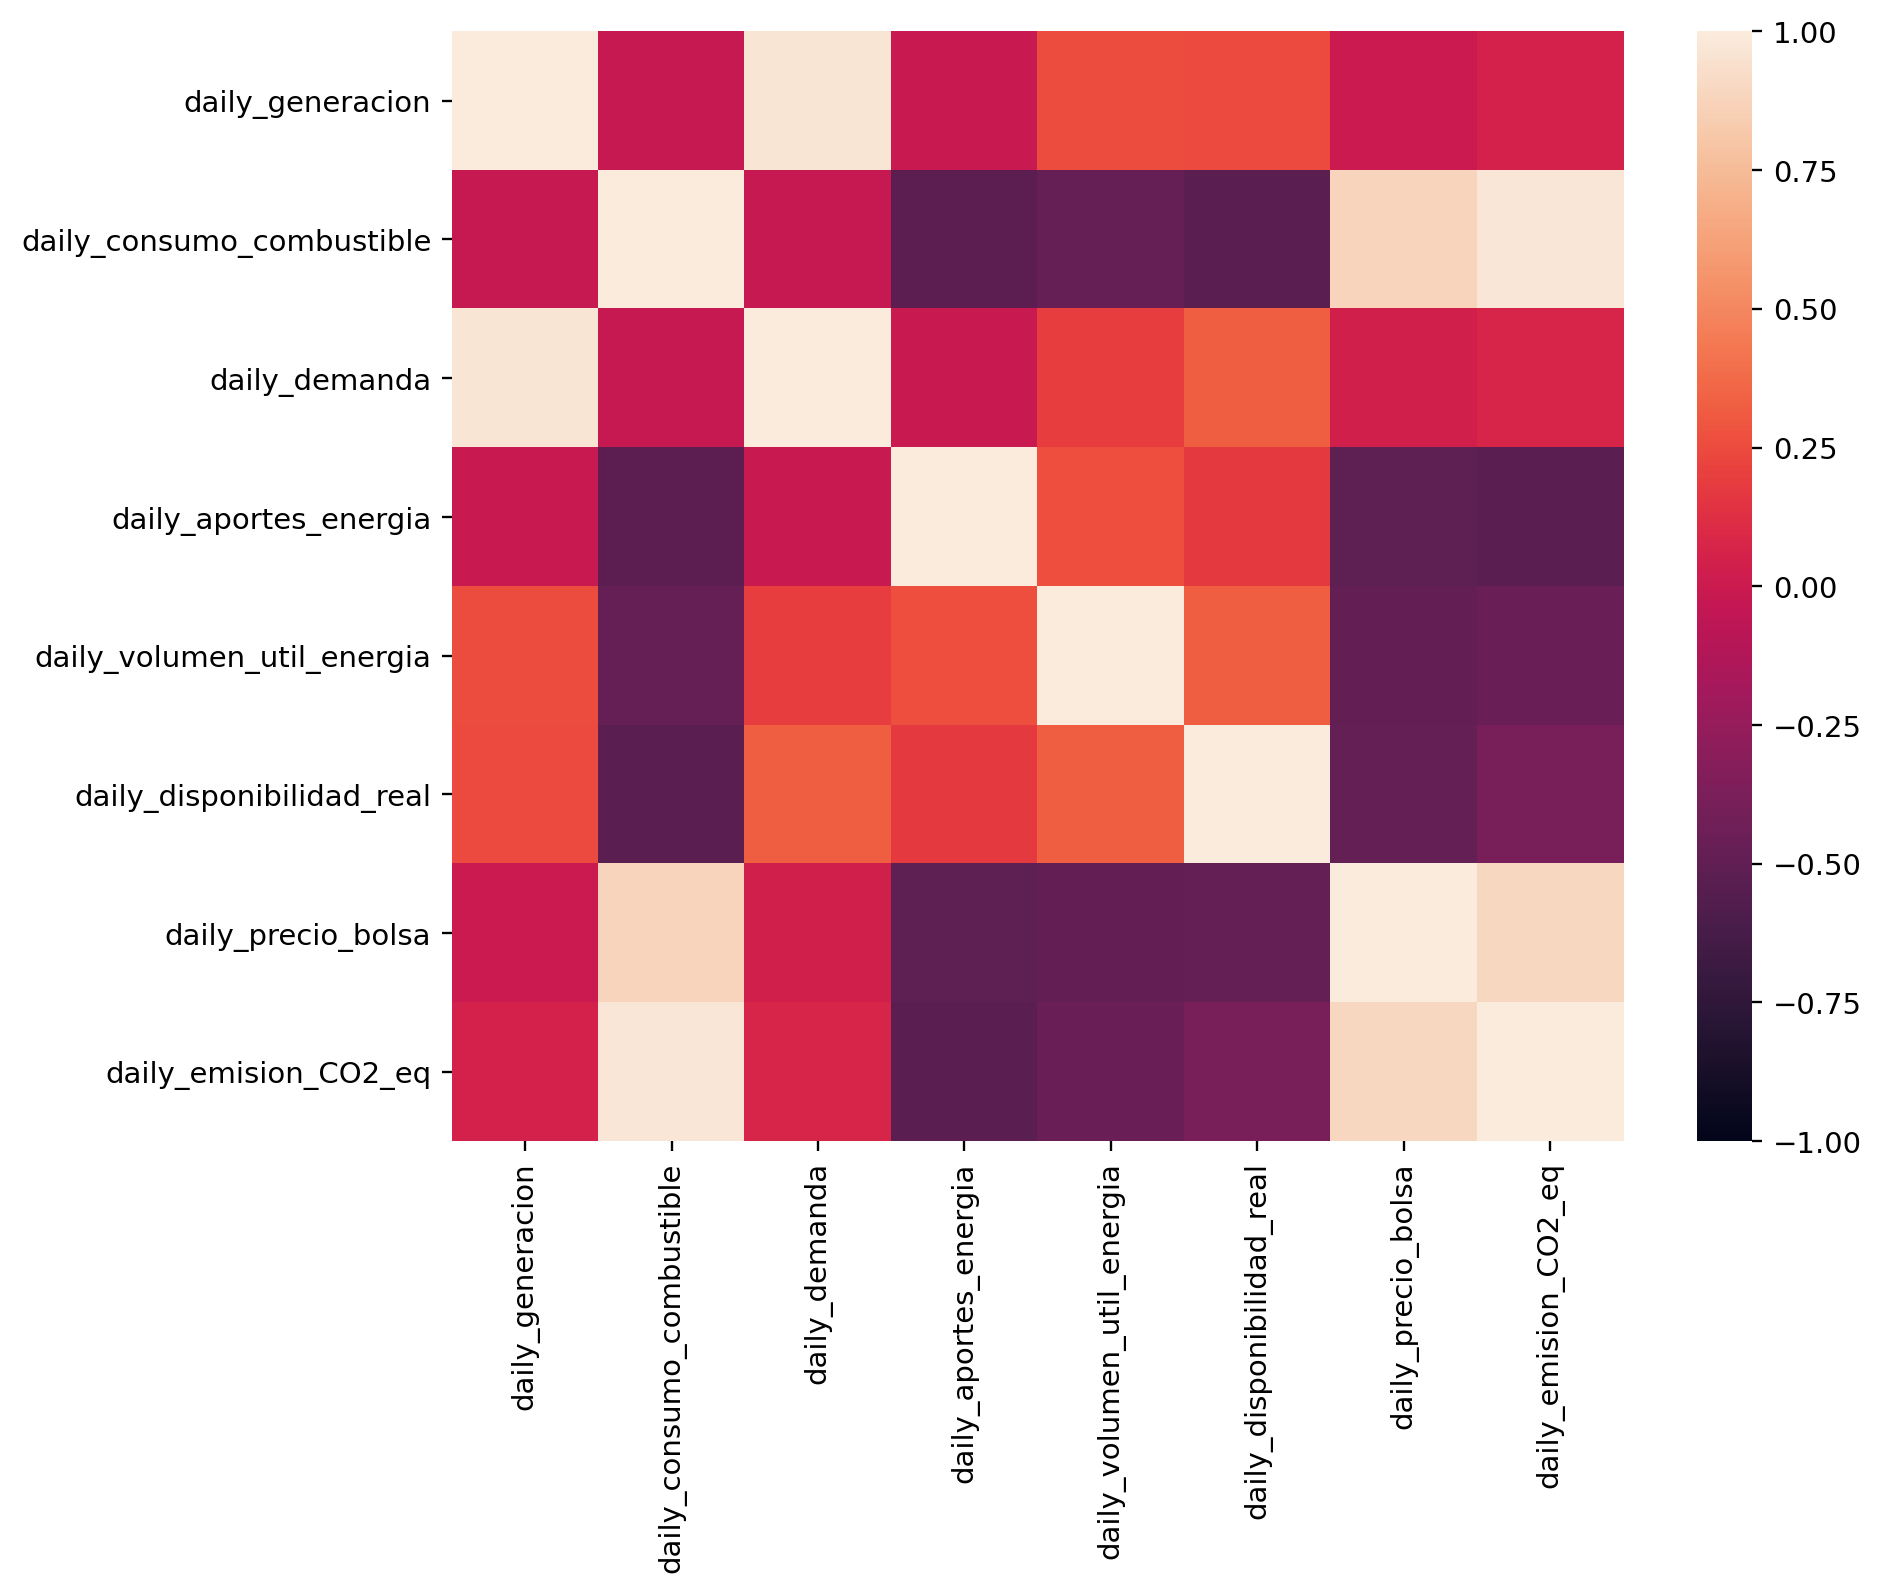

In [298]:
df_power_co.drop('Unnamed: 0', inplace=True, axis=1)
corr_matrix = df_power_co.corr(method='spearman')
sns.heatmap(corr_matrix, vmin=-1, vmax=1);

De este análisis de correlaciones podemos concluir:
1. Que las siguientes varaibles tienen una relacion directa con las emisiones de $CO_2eq$:
  * Consumo de combustible (0.968)
  * Precio de bolsa (0.893)
  * Demanda (0.072)
  * Generación (0.049)
2. Que las siguientes variables tienen una relación inversa con las emisiones $CO_2eq$:
  * Aportes de energía (-0.528)
  * Volumen útil de energía (-0.457)
  * Disponibilidad real (-0.384)

A continuación se grafican estas relaciones:

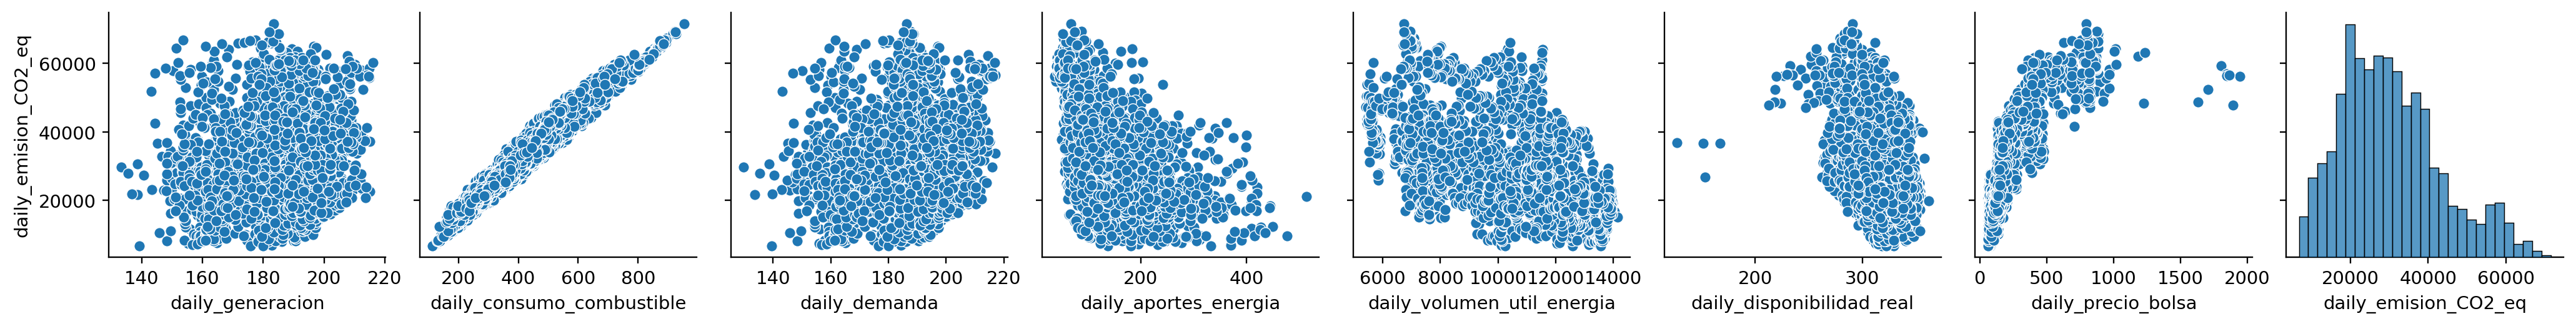

In [299]:
sns.pairplot(df_power_co,y_vars=['daily_emision_CO2_eq']);

#### **3.2.1 Acondicionamiento de las sieries de tiempo a modelar**
---

In [300]:
df_ts_multivar = df_power_co.set_index('Date')
df_ts_multivar

daily_generacion  ...  daily_emision_CO2_eq
Date                          ...                      
2013-10-01        172.693215  ...          26770.660000
2013-10-02        176.526617  ...          19434.710000
2013-10-03        179.807460  ...          28364.490000
2013-10-04        173.452142  ...          31935.540000
2013-10-05        164.918611  ...          30412.380000
...                      ...  ...                   ...
2020-12-31        176.650730  ...          28940.544818
2021-01-01        155.591653  ...          21541.065537
2021-01-02        168.340658  ...          21602.982213
2021-01-03        168.073034  ...          21277.745423
2021-01-04        189.681741  ...          24488.932354

[2653 rows x 8 columns]

In [301]:
df_ts_multivar.columns

Index(['daily_generacion', 'daily_consumo_combustible', 'daily_demanda',
       'daily_aportes_energia', 'daily_volumen_util_energia',
       'daily_disponibilidad_real', 'daily_precio_bolsa',
       'daily_emision_CO2_eq'],
      dtype='object')

##### **3.2.1.2 Escalamiento de los datos**
---

In [302]:
scaler_multi = StandardScaler()

for column in df_ts_multivar.columns:
  df_ts_multivar[column] = scaler.fit_transform(df_ts_multivar[column].values.reshape(-1, 1))

df_ts_multivar

daily_generacion  ...  daily_emision_CO2_eq
Date                          ...                      
2013-10-01         -0.810288  ...             -0.282952
2013-10-02         -0.537157  ...             -0.852378
2013-10-03         -0.303395  ...             -0.159237
2013-10-04         -0.756215  ...              0.117953
2013-10-05         -1.364233  ...             -0.000277
...                      ...  ...                   ...
2020-12-31         -0.528314  ...             -0.114523
2021-01-01         -2.028783  ...             -0.688880
2021-01-02         -1.120410  ...             -0.684074
2021-01-03         -1.139479  ...             -0.709319
2021-01-04          0.400152  ...             -0.460062

[2653 rows x 8 columns]

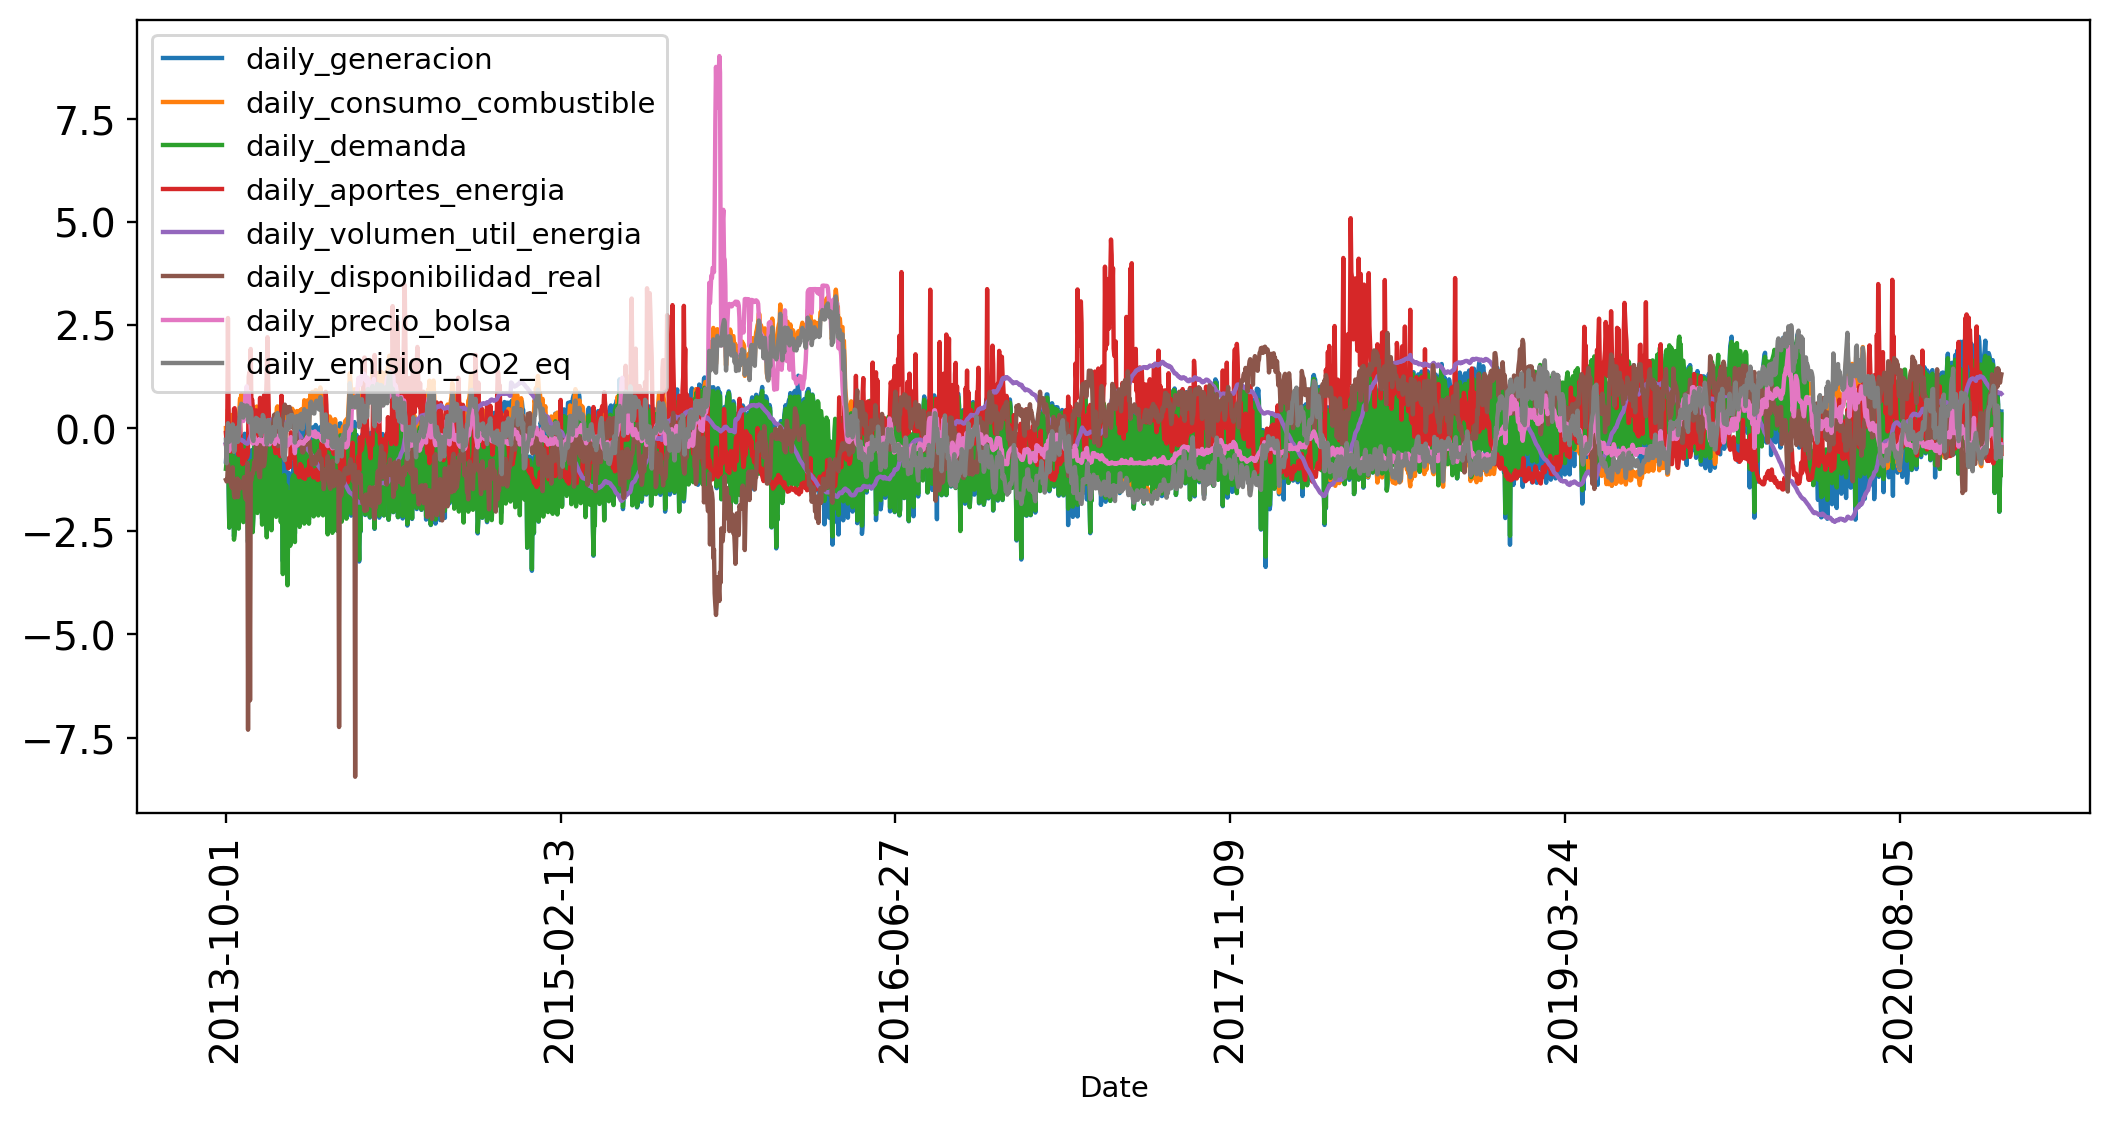

In [303]:
df_ts_multivar.plot(rot=90, figsize = (12, 5), fontsize = 13.5);

#### **3.2.2 Particion de los datos y validación Cruzada**
---

In [304]:
data_multi_train = df_ts_multivar.loc[:'2018-10-01']  # Primeros 5 años
data_multi_test  = df_ts_multivar.loc['2018-10-02':]  # Últimos 2 años.

data_multi_train.index[-1], data_multi_test.index[0] # Fechas de inicio de ambos conjuntos.

('2018-10-01', '2018-10-02')

In [305]:
data_multi_train

daily_generacion  ...  daily_emision_CO2_eq
Date                          ...                      
2013-10-01         -0.810288  ...             -0.282952
2013-10-02         -0.537157  ...             -0.852378
2013-10-03         -0.303395  ...             -0.159237
2013-10-04         -0.756215  ...              0.117953
2013-10-05         -1.364233  ...             -0.000277
...                      ...  ...                   ...
2018-09-27          0.993895  ...             -0.334957
2018-09-28          0.998135  ...             -0.363967
2018-09-29          0.452344  ...             -0.319148
2018-09-30         -0.848620  ...             -0.451065
2018-10-01          0.928662  ...             -0.243400

[1827 rows x 8 columns]

In [306]:
# Creamos las ventanas y sus valores a predecir para entrenamiento y validación.

def multi_var_slinding_time(df, window_size, objetive_var):
  X_train, y_train = sliding_time(df[objetive_var].values, window_size=k)

  for feature in df.columns:
    if feature!=objetive_var:
      X_multi, y_multi = sliding_time(df[feature].values, window_size=k)
      X_multi = np.append(X_multi, y_multi.reshape(-1,1), axis=1)
      X_train = np.append(X_train, X_multi, axis=1)

  return X_train, y_train

In [307]:
k=20
X_train, y_train = multi_var_slinding_time(data_multi_train, k,'daily_emision_CO2_eq')

In [308]:
pd.DataFrame(X_train)

0         1         2    ...       164       165       166
0    -0.282952 -0.852378 -0.159237  ... -0.226102 -0.136491 -0.142507
1    -0.852378 -0.159237  0.117953  ... -0.136491 -0.142507  0.164607
2    -0.159237  0.117953 -0.000277  ... -0.142507  0.164607  0.187931
3     0.117953 -0.000277 -0.331083  ...  0.164607  0.187931  0.195128
4    -0.000277 -0.331083 -0.233256  ...  0.187931  0.195128  0.218476
...        ...       ...       ...  ...       ...       ...       ...
1802 -0.963048 -1.013402 -1.058799  ... -0.453537 -0.457113 -0.494241
1803 -1.013402 -1.058799 -0.214309  ... -0.457113 -0.494241 -0.438176
1804 -1.058799 -0.214309 -0.447473  ... -0.494241 -0.438176 -0.384311
1805 -0.214309 -0.447473 -0.566862  ... -0.438176 -0.384311 -0.502966
1806 -0.447473 -0.566862 -0.525027  ... -0.384311 -0.502966 -0.346164

[1807 rows x 167 columns]

In [309]:
print(f'Número de variables: {(X_train.shape[1]-7)/k}')
print(f"Número de ejemplos de entrenamiento: {X_train.shape[0]} (Ventana de tamaño {k})")
print(f"Número de valores a predecir: {y_train.shape[0]}")

Número de variables: 8.0
Número de ejemplos de entrenamiento: 1807 (Ventana de tamaño 20)
Número de valores a predecir: 1807


In [310]:
X_test, y_test = multi_var_slinding_time(data_multi_test, k,'daily_emision_CO2_eq')

In [311]:
print(f'Número de variables: {(X_test.shape[1]-7)/k}')
print(f"Número de ejemplos de prueba: {X_test.shape[0]} (Ventana de tamaño {k})")
print(f"Número de valores a predecir: {y_test.shape[0]}")

Número de variables: 8.0
Número de ejemplos de prueba: 806 (Ventana de tamaño 20)
Número de valores a predecir: 806


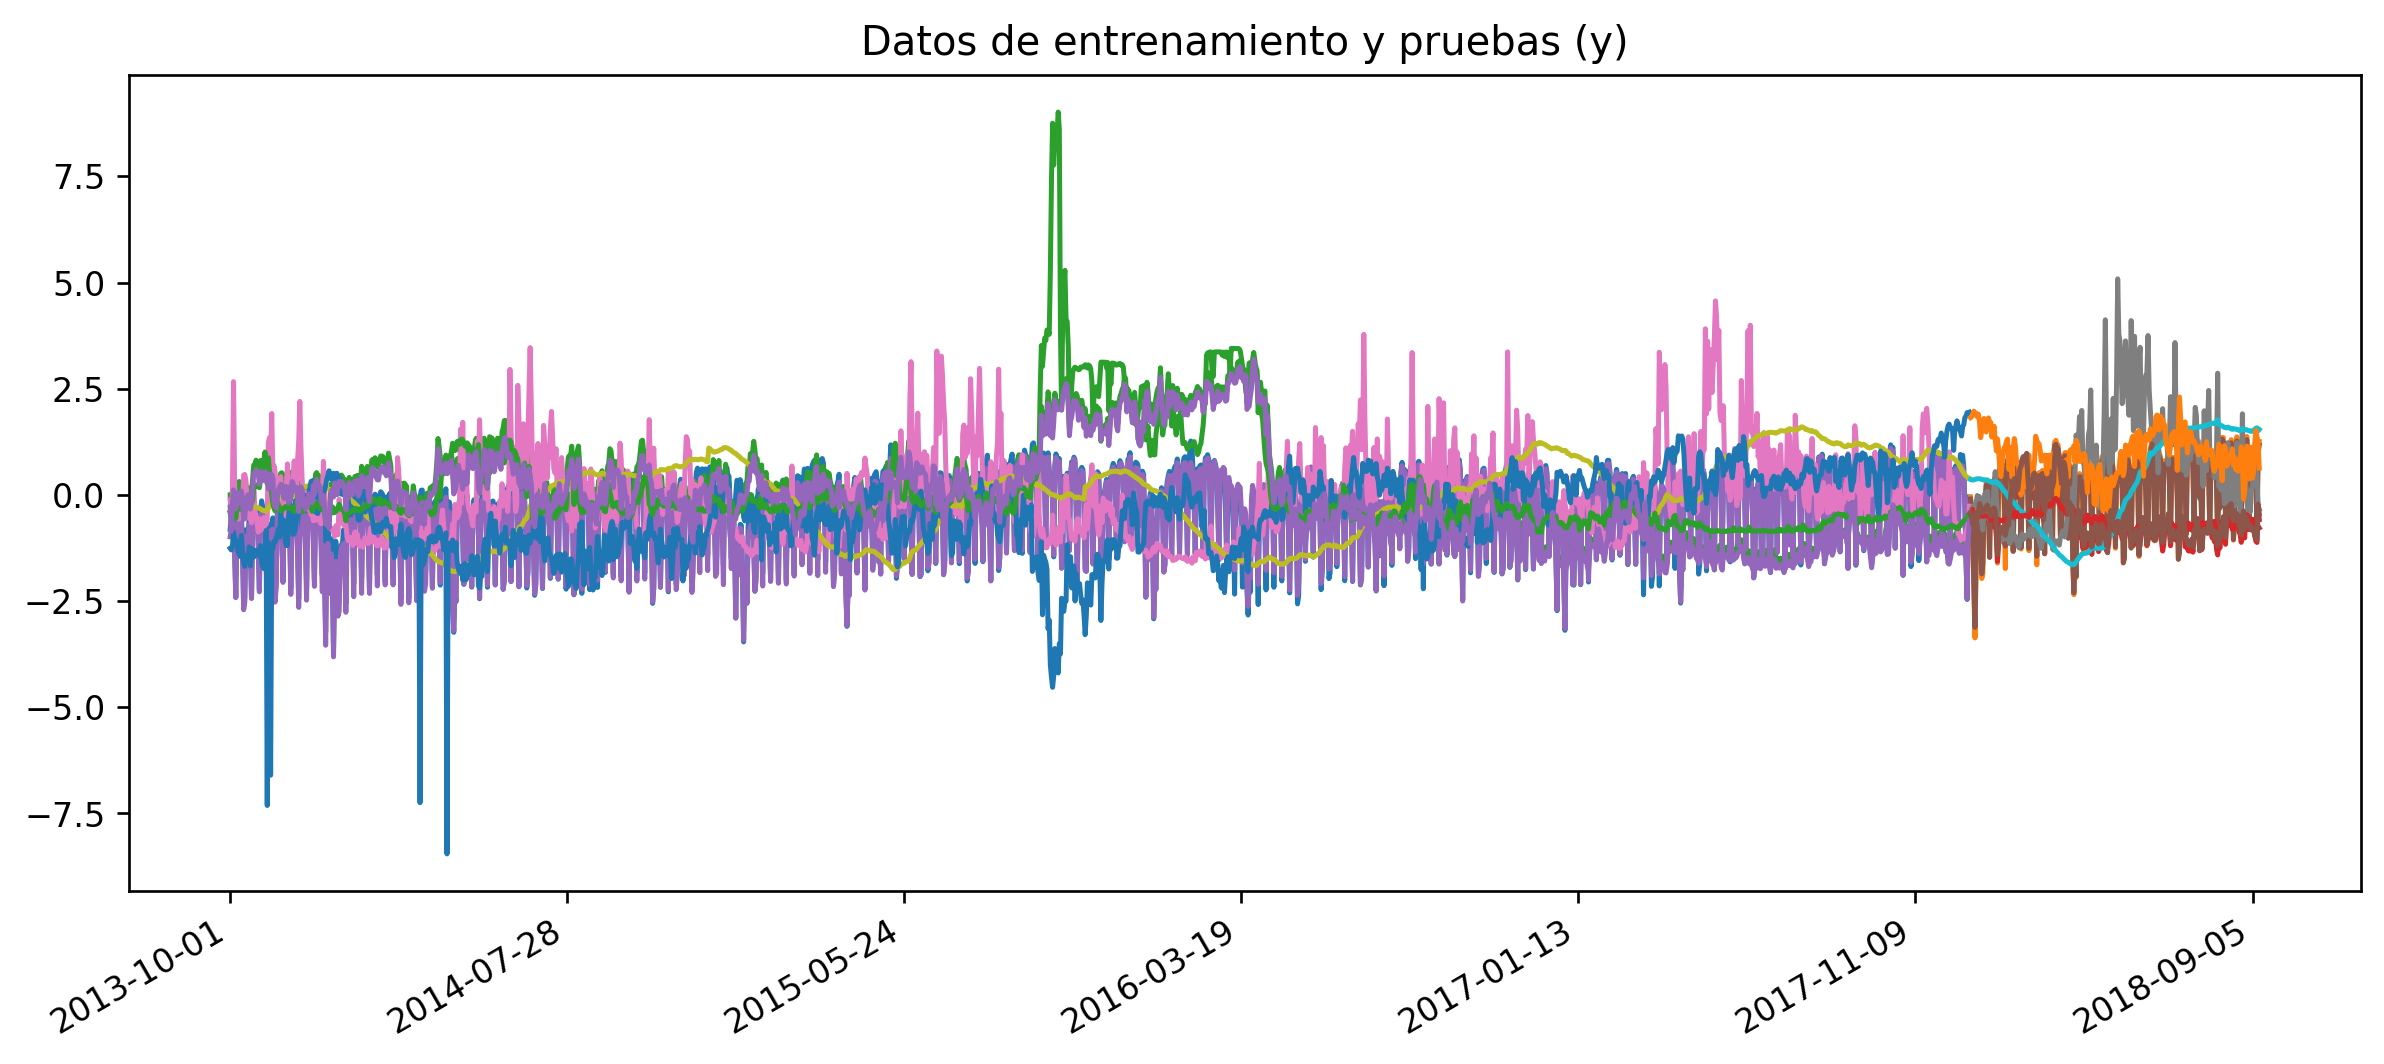

In [312]:
# Datos de prueba y entrenamiento con Matplotlib
tsp = TimeSeriesSplit(n_splits=n_splits)

tsp_indexes = [(train_index, test_index) for (train_index, test_index) in tsp.split(X_train, y_train)]
train_index, test_index = tsp_indexes[-1]

fig = plt.figure(dpi = 120, figsize = (12, 5))
for column in df_ts_multivar.columns:

  plt.plot(df_ts_multivar[column][train_index].index, df_ts_multivar[column][train_index].values, label = "Entrenamiento (y)"+column)
  plt.plot(df_ts_multivar[column][test_index].index, df_ts_multivar[column][test_index].values, label = "Prueba (y)"+column)

plt.xticks(np.arange(0, 1900, 300))
plt.title('Datos de entrenamiento y pruebas (y)')
fig.autofmt_xdate()
plt.show()

#### **3.2.3 Regresión con Perceptrón Multicapa**
---

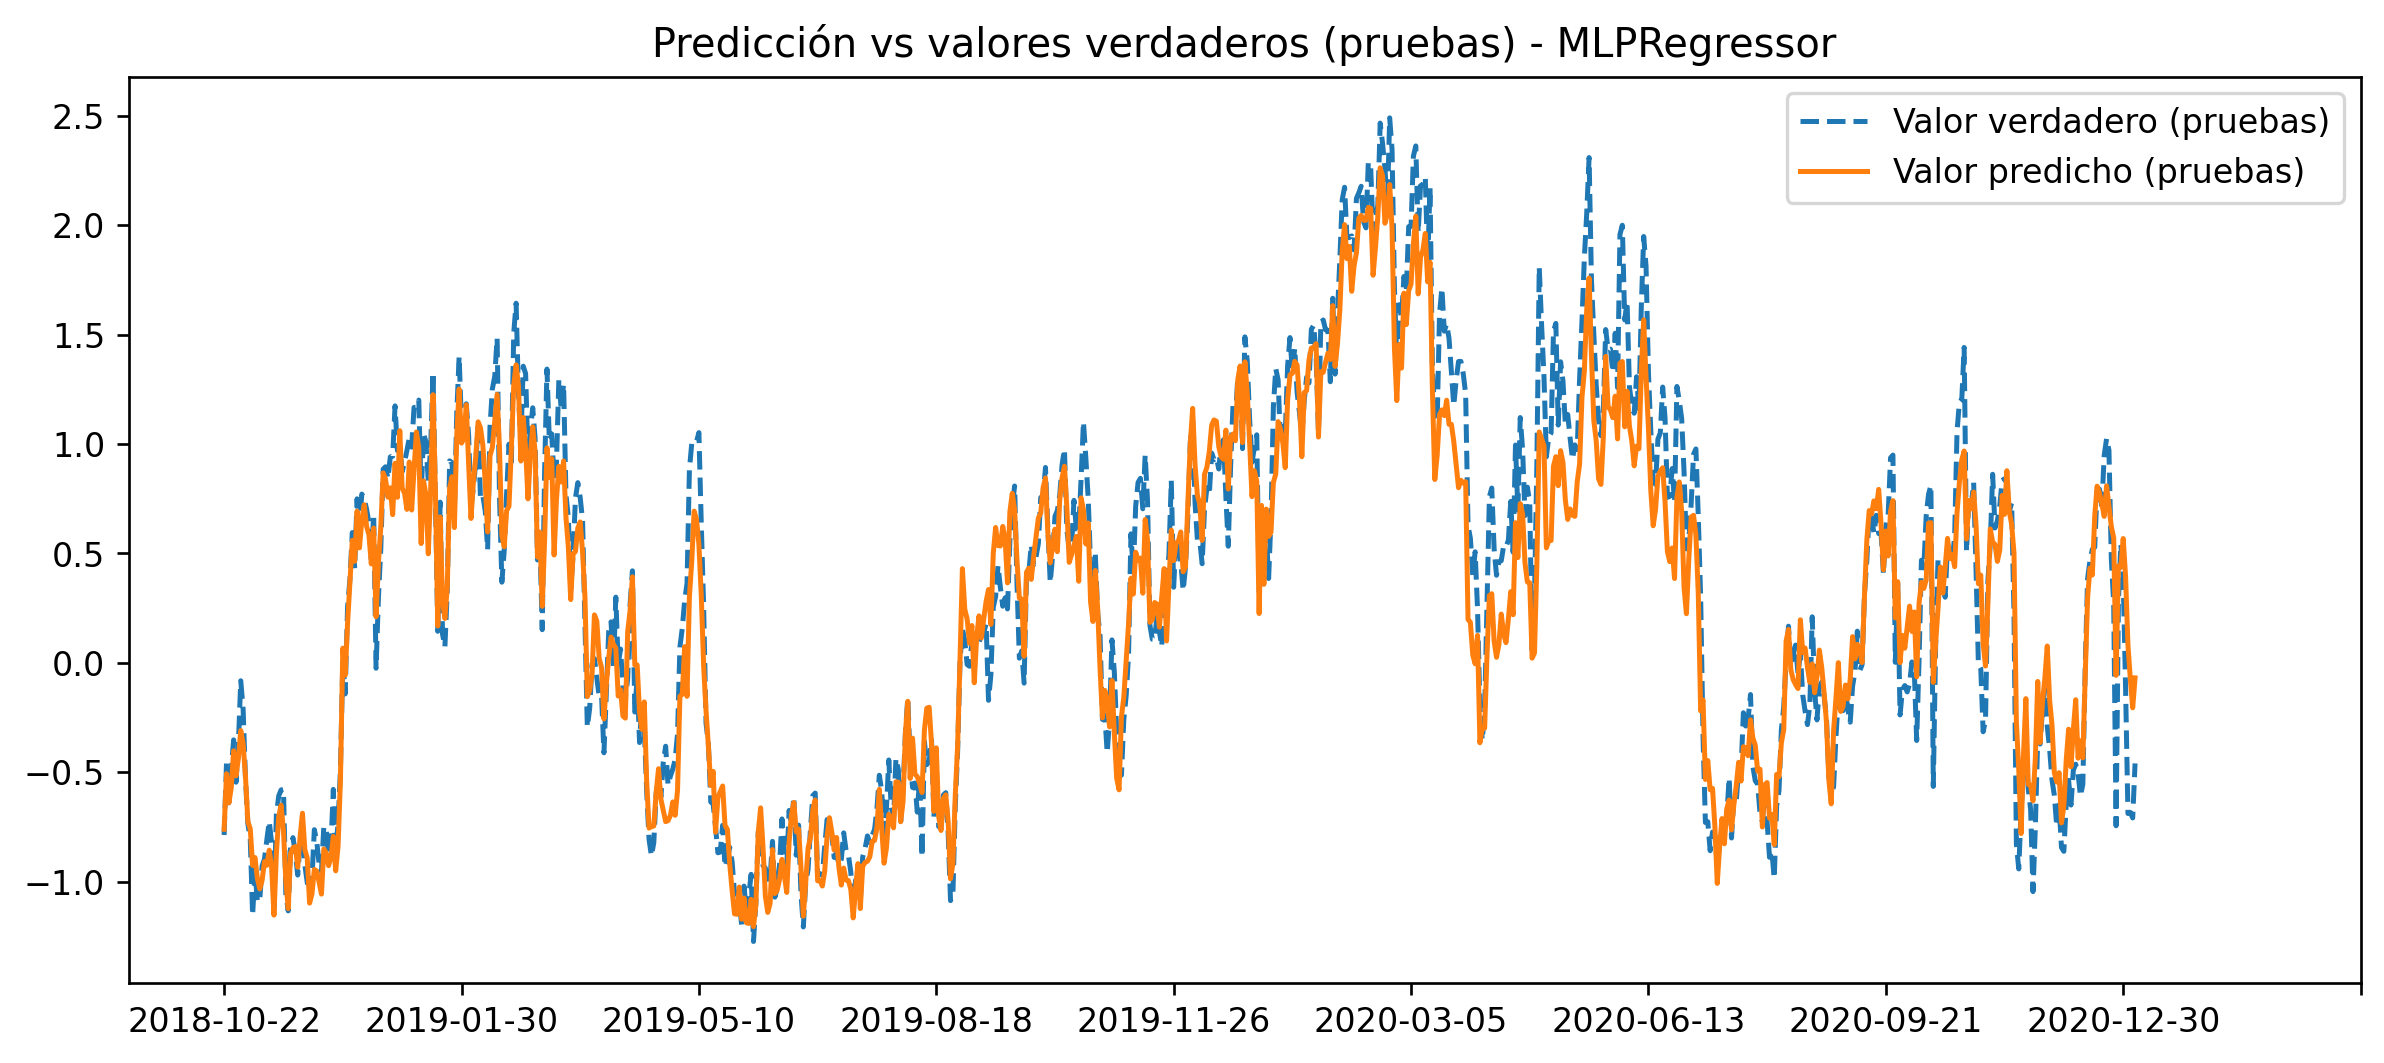

In [313]:
model = MLPRegressor(solver = 'lbfgs',
                   activation = 'relu',
                   hidden_layer_sizes=(120, 60, 30),
                   max_iter=200,                   
                   n_iter_no_change=50, 
                   validation_fraction=0.2,               
                   random_state=1234)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
x = data_multi_test.index[k:]

fig = plt.figure(dpi = 120, figsize = (12, 5))
plt.plot(x, y_test, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_pred, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas) - MLPRegressor")
plt.xticks(np.arange(0, 1000, 100))
plt.legend();

##### **3.2.3.1 Busqueda de Hiperparametros**
---

In [314]:
params_MLP = {    
      'hidden_layer_sizes' : [(240,120,60,20), (120, 80,40,20), (80,40,20,10)], # Algunas arquitecturas propuestas.
      'activation' : ['tanh', 'relu'],
      'solver': ['adam', 'lbfgs']
 }

In [315]:
tsp = TimeSeriesSplit(n_splits = 3)

gsearch = GridSearchCV(estimator = MLPRegressor(random_state=1234,
                                                max_iter= 2000,
                                                n_iter_no_change=50, 
                                                validation_fraction=0.2), 
                        cv = tsp,
                        param_grid = params_MLP, 
                        verbose = 3)

gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam, score=0.424, total=   3.7s
[CV] activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam, score=0.034, total=   8.9s
[CV] activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s


[CV]  activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=adam, score=0.512, total=   7.6s
[CV] activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=lbfgs, score=0.319, total=   4.9s
[CV] activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=lbfgs, score=0.821, total=  12.3s
[CV] activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(240, 120, 60, 20), solver=lbfgs, score=0.872, total=  17.1s
[CV] activation=tanh, hidden_layer_sizes=(120, 80, 40, 20), solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(120, 80, 40, 20), solver=adam, score=0.416, total=   1.9s
[CV] activation=tanh, hidden_layer_sizes=(120, 80, 40, 20), solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(120, 80, 40, 20), solver=adam, score=0.642, total=   3.9s
[CV] activation=

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=2000, momentum=0.9,
                                    n_iter_no_change=50,
                                    ne...
                                    random_state=1234, shuffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.2, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
        

In [316]:
best_MLP_models = pd.DataFrame(gsearch.cv_results_).nlargest(10, 'mean_test_score')
best_MLP_models

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
5        4.431570      2.476320  ...        0.109218                1
1       11.430761      4.993239  ...        0.249254                2
3        6.633670      3.547832  ...        0.229132                3
4        2.680316      0.968706  ...        0.082598                4
2        3.620211      1.277398  ...        0.170208                5
7        8.478899      4.203159  ...        0.256675                6
8        2.432339      1.052209  ...        0.004426                7
11       6.000428      3.108699  ...        0.523705                8
10       2.105601      0.715044  ...        0.304090                9
9        5.249959      2.777904  ...        0.355337               10

[10 rows x 14 columns]

In [317]:
# Últimos valores de entrenamiento a usar para la predicción.
X_last = X_test[:1]

# Listas con los datos en y, empezando desde el primer valor de pruebas.
y_last = [] 
y_forward = []

for i in range(len(X_test)):  
  # Valores predichos a partir de datos reales (X_test)
  y_pred_forward = gsearch.predict(X_test[i: i + 1]) 
  y_forward.append(y_pred_forward[0])  

  # Valores predichos a partir de datos predichos y retroalimentados.
  y_pred_last = gsearch.predict(X_last)  # Se predice el valor siguiente a partir de datos predichos previamente.
  y_last.append(y_pred_last[0])          # Guardamos el valor predicho.

  # Creación de la nueva ventana añadiendo la última predicción.
  X_last = np.roll(X_last, -1)           # Desplazamos todos los valores hacia la izquierda con np.roll
  X_last[0,-1] = y_pred_last             # Guardamos el valor predicho en la última posición del arreglo.

#Gráficamos las 2 predicciones distintas en comparación con los valores reales.

test_date_index = data_multi_test.index[k:]
plot_prediction_new(gsearch.best_params_, 
                (y_test, y_forward),
                 test_date_index)

In [318]:
df_one_day_predictions_multi = pd.DataFrame()
df_one_day_predictions_multi['y_test'] = y_test
df_one_day_predictions_multi['y_MLP'] = y_forward

#### **3.2.4 Regresión con Random Forest**
---

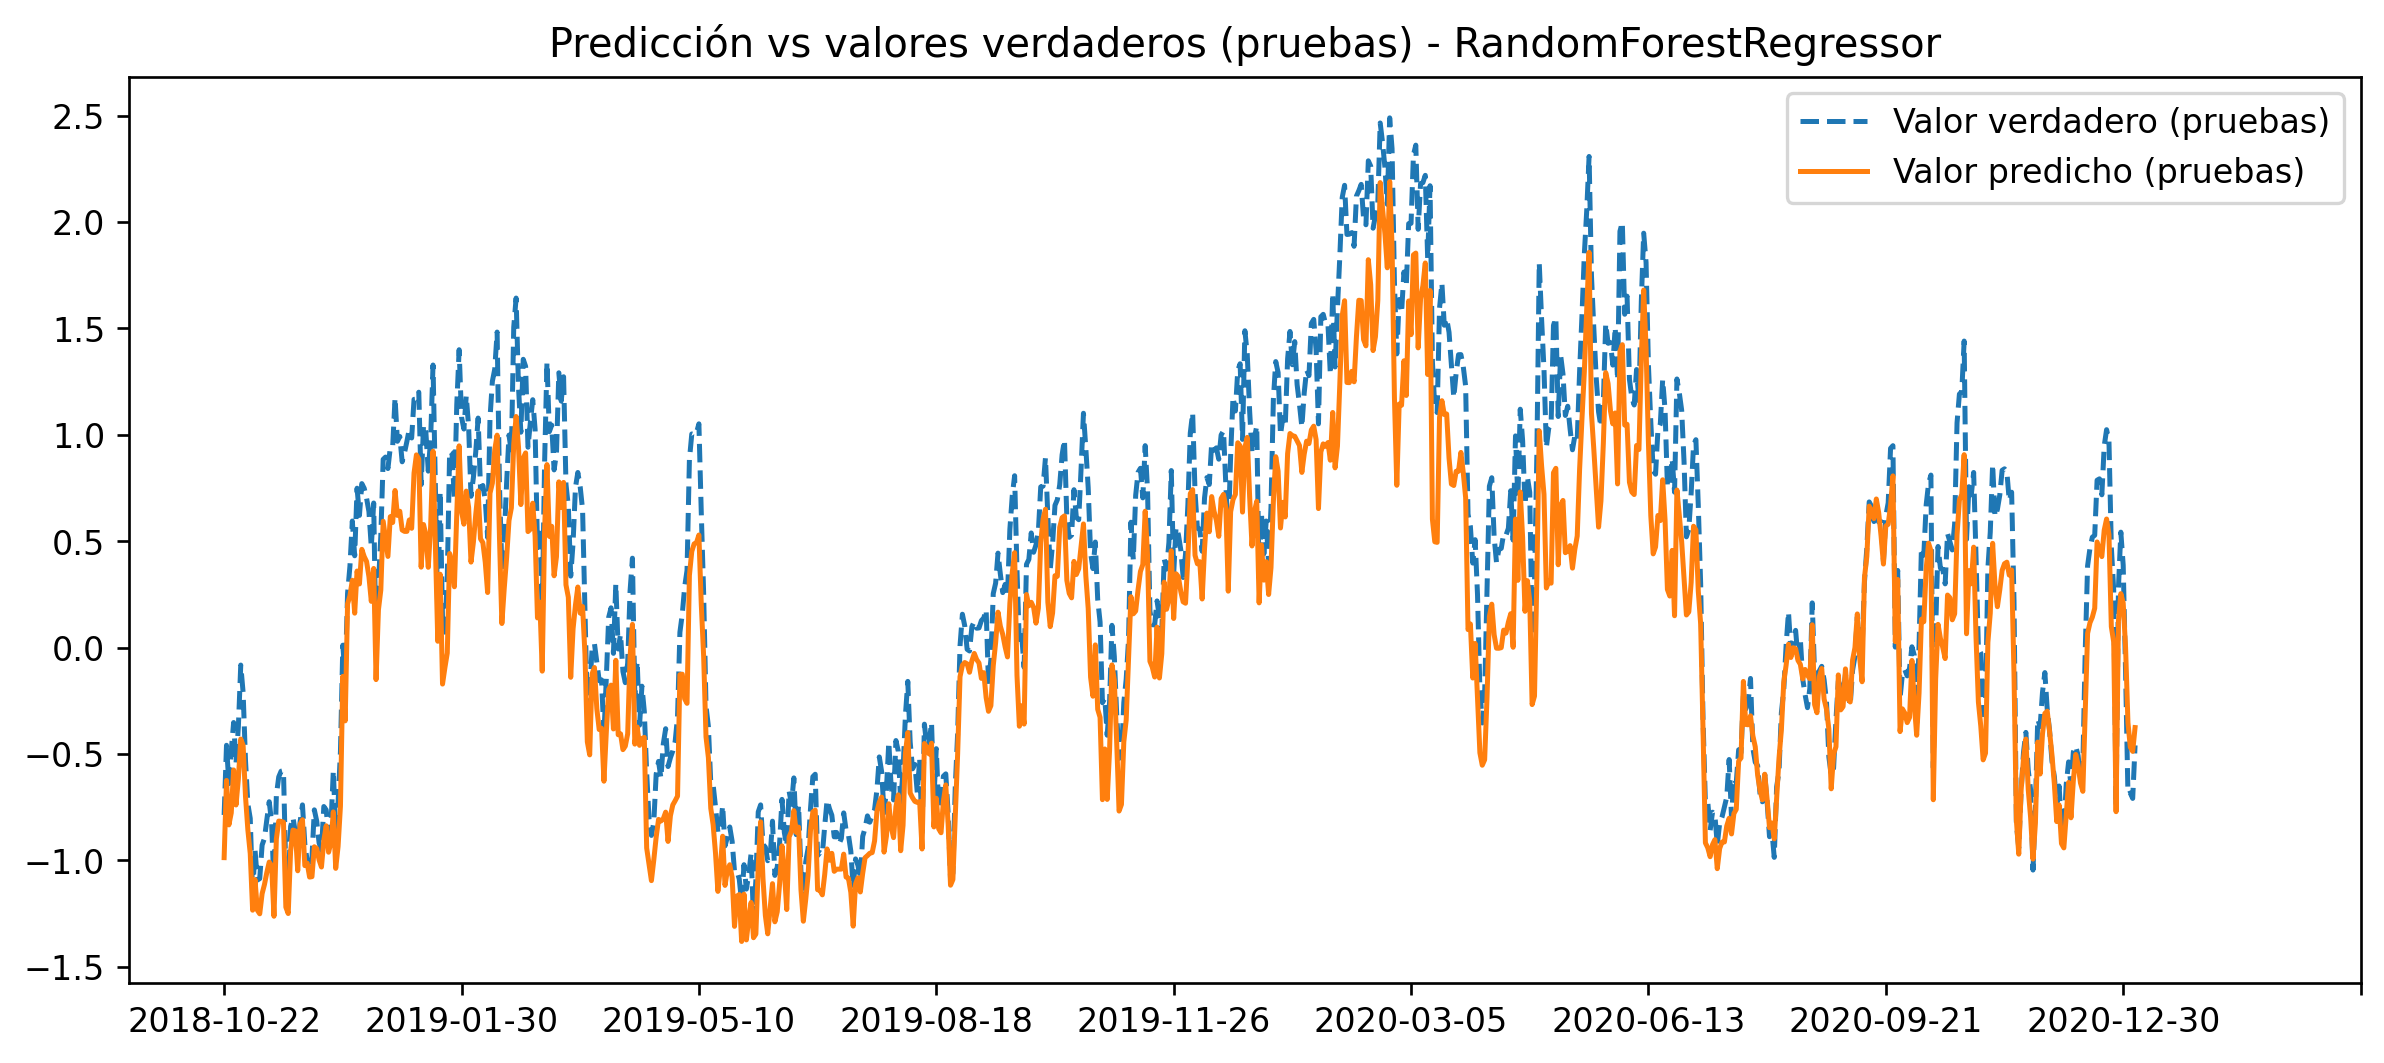

In [319]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
x = data_test.index[k:]

fig = plt.figure(dpi = 120, figsize = (12, 5))
plt.plot(x, y_test, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_pred, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas) - RandomForestRegressor")
plt.xticks(np.arange(0, 1000, 100))
plt.legend();

##### **3.2.4.1 Busqueda de hiperparametros**
---

In [320]:
params_RFR = { 
    'n_estimators': [3,6,12,24,52,104],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,100,1000]
    #'min_samples_leaf': [1,2],
    #'min_samples_split': [2,3]
    }

In [321]:
tsp = TimeSeriesSplit(n_splits = 3)

gsearch = GridSearchCV(estimator = RandomForestRegressor(random_state = 42), 
                        cv = tsp,
                        param_grid = params_RFR, 
                        verbose = 3)

gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] max_depth=10, max_features=auto, n_estimators=3 .................
[CV]  max_depth=10, max_features=auto, n_estimators=3, score=0.580, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=3 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=3, score=0.604, total=   0.2s
[CV] max_depth=10, max_features=auto, n_estimators=3 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=3, score=0.794, total=   0.3s
[CV] max_depth=10, max_features=auto, n_estimators=6 .................
[CV]  max_depth=10, max_features=auto, n_estimators=6, score=0.623, total=   0.2s
[CV] max_depth=10, max_features=auto, n_estimators=6 .................
[CV]  max_depth=10, max_features=auto, n_estimators=6, score=0.618, total=   0.4s
[CV] max_depth=10, max_features=auto, n_estimators=6 .................
[CV]  max_depth=10, max_features=auto, n_estimators=6, score=0.802, total=   0.6s
[CV] max_depth=10, max_features=auto, n_estimators=12 ................
[CV]  max_depth=10, max_features=auto, n_estimators=12, score=0.607, total=   0.3s
[CV] max_depth=10, max_features=auto, n_estimators=12 ................
[CV]  max_depth=10, max_features=auto, n_estimators=12, score=0.583, total=   0.8s
[CV] max_depth=10, max_features=auto, n_estimators=12 ................
[CV]  max_depth=10, max_features=auto, n_estimators=12, score=0.804, total=   1.

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  2.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose

In [322]:
# Los mejores 10 modelos con respecto a su mean_test_score.
best_RFR_models = pd.DataFrame(gsearch.cv_results_).nlargest(10, 'mean_test_score')
best_RFR_models

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
4        3.175868      1.467442  ...        0.080433                1
22       3.428437      1.636570  ...        0.081725                2
40       3.431894      1.665172  ...        0.081725                2
5        6.371101      2.916928  ...        0.084146                4
23       6.878894      3.324826  ...        0.084429                5
41       6.829216      3.298975  ...        0.084429                5
3        1.487693      0.683188  ...        0.082698                7
19       0.401767      0.197906  ...        0.081847                8
37       0.404882      0.202261  ...        0.081847                8
21       1.585544      0.768947  ...        0.087521               10

[10 rows x 14 columns]

In [323]:
X_last = X_test[:1]

# Listas con los datos en y, empezando desde el primer valor de pruebas.
y_last = [] 
y_forward = []

for i in range(len(X_test)):  
  # Valores predichos a partir de datos reales (X_test)
  y_pred_forward = gsearch.predict(X_test[i: i + 1]) 
  y_forward.append(y_pred_forward[0])  

  # Valores predichos a partir de datos predichos y retroalimentados.
  y_pred_last = gsearch.predict(X_last)  # Se predice el valor siguiente a partir de datos predichos previamente.
  y_last.append(y_pred_last[0])          # Guardamos el valor predicho.

  # Creación de la nueva ventana añadiendo la última predicción.
  X_last = np.roll(X_last, -1)           # Desplazamos todos los valores hacia la izquierda con np.roll
  X_last[0,-1] = y_pred_last             # Guardamos el valor predicho en la última posición del arreglo.

#Gráficamos las 2 predicciones distintas en comparación con los valores reales.

test_date_index = data_test.index[k:]
plot_prediction_new(gsearch.best_params_, 
                (y_test, y_forward),
                 test_date_index)
df_one_day_predictions_multi['y_RFR'] = y_forward

#### **3.2.5 Regresion con Support Vector Machines**
---

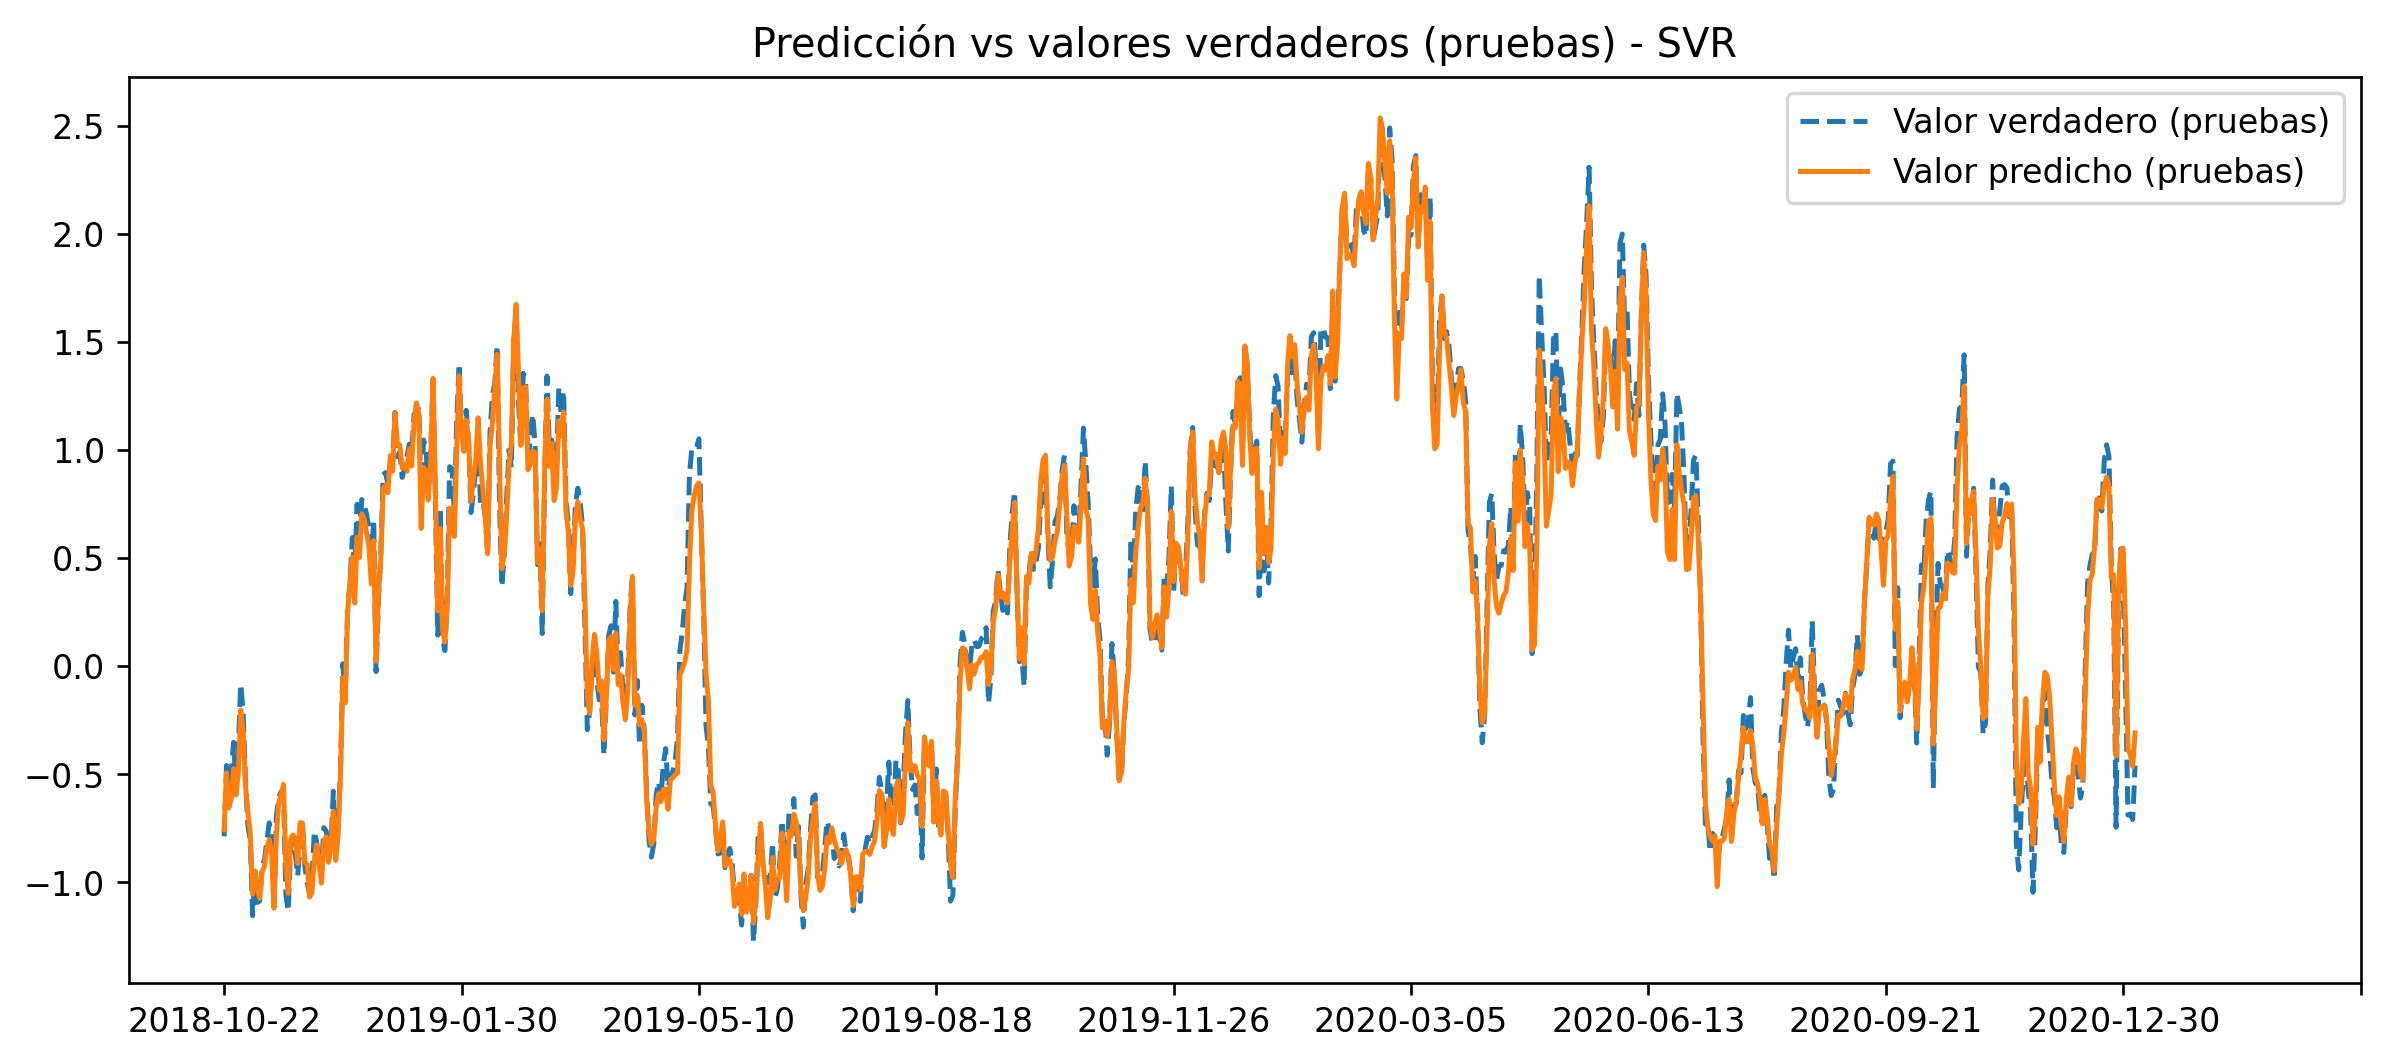

In [324]:
svr_rbf = SVR(C=1000, degree= 2, epsilon= 0.1, gamma= 0.0001, kernel='rbf')
svr_rbf.fit(X_train, y_train)
y_pred = svr_rbf.predict(X_test)

x = data_test.index[k:]

fig = plt.figure(dpi = 120, figsize = (12, 5))
plt.plot(x, y_test, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_pred, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas) - SVR")
plt.xticks(np.arange(0, 1000, 100))
plt.legend();

##### **3.2.5.1 Busqueda de hiperparametros**
---

In [325]:
params_SVR = {'C': [1, 10, 100, 1000],
          'kernel': ['rbf','poly'],
          'gamma': [0.01,0.001, 0.0001],
          'degree': [2,3,4,5,6,8],
          'epsilon': [0.1,0.2]}

In [326]:
tsp = TimeSeriesSplit(n_splits = 3)

gsearch = GridSearchCV(estimator = SVR(), 
                        cv = tsp,
                        param_grid = params_SVR, 
                        verbose = 3)

gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf ..............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf, score=-0.299, total=   0.1s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf, score=-3.389, total=   0.3s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf, score=0.715, total=   0.5s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly, score=0.658, total=   0.1s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly, score=-6.252, total=   0.3s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly, score=-0.859, total=   0.7s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.673, total=   0.1s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.180, total=   0.2s
[CV] C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf .............
[CV]  C=1, degree=2, epsilon=0.1, gamma=0.001, kernel=rbf

[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:  3.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000], 'degree': [2, 3, 4, 5, 6, 8],
                         'epsilon': [0.1, 0.2], 'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [327]:
# Los mejores 10 modelos con respecto a su mean_test_score.
best_SVM_models = pd.DataFrame(gsearch.cv_results_).nlargest(10, 'mean_test_score')
best_SVM_models

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
220       0.163937      0.090198  ...        0.005610                1
232       0.167030      0.086584  ...        0.005610                1
244       0.165017      0.089691  ...        0.005610                1
256       0.166176      0.089617  ...        0.005610                1
268       0.166590      0.090913  ...        0.005610                1
280       0.168508      0.088253  ...        0.005610                1
148       0.148540      0.083082  ...        0.008276                7
160       0.149297      0.083262  ...        0.008276                7
172       0.148262      0.082391  ...        0.008276                7
184       0.147167      0.079959  ...        0.008276                7

[10 rows x 16 columns]

In [328]:
X_last = X_test[:1]

# Listas con los datos en y, empezando desde el primer valor de pruebas.
y_last = [] 
y_forward = []

for i in range(len(X_test)):  
  # Valores predichos a partir de datos reales (X_test)
  y_pred_forward = gsearch.predict(X_test[i: i + 1]) 
  y_forward.append(y_pred_forward[0])  

  # Valores predichos a partir de datos predichos y retroalimentados.
  y_pred_last = gsearch.predict(X_last)  # Se predice el valor siguiente a partir de datos predichos previamente.
  y_last.append(y_pred_last[0])          # Guardamos el valor predicho.

  # Creación de la nueva ventana añadiendo la última predicción.
  X_last = np.roll(X_last, -1)           # Desplazamos todos los valores hacia la izquierda con np.roll
  X_last[0,-1] = y_pred_last             # Guardamos el valor predicho en la última posición del arreglo.

#Gráficamos las 2 predicciones distintas en comparación con los valores reales.

test_date_index = data_test.index[k:]
plot_prediction_new(gsearch.best_params_, 
                (y_test, y_forward),
                 test_date_index)
df_one_day_predictions_multi['y_SVM'] = y_forward

#### **3.2.6 Regresión con XGBoost**
---

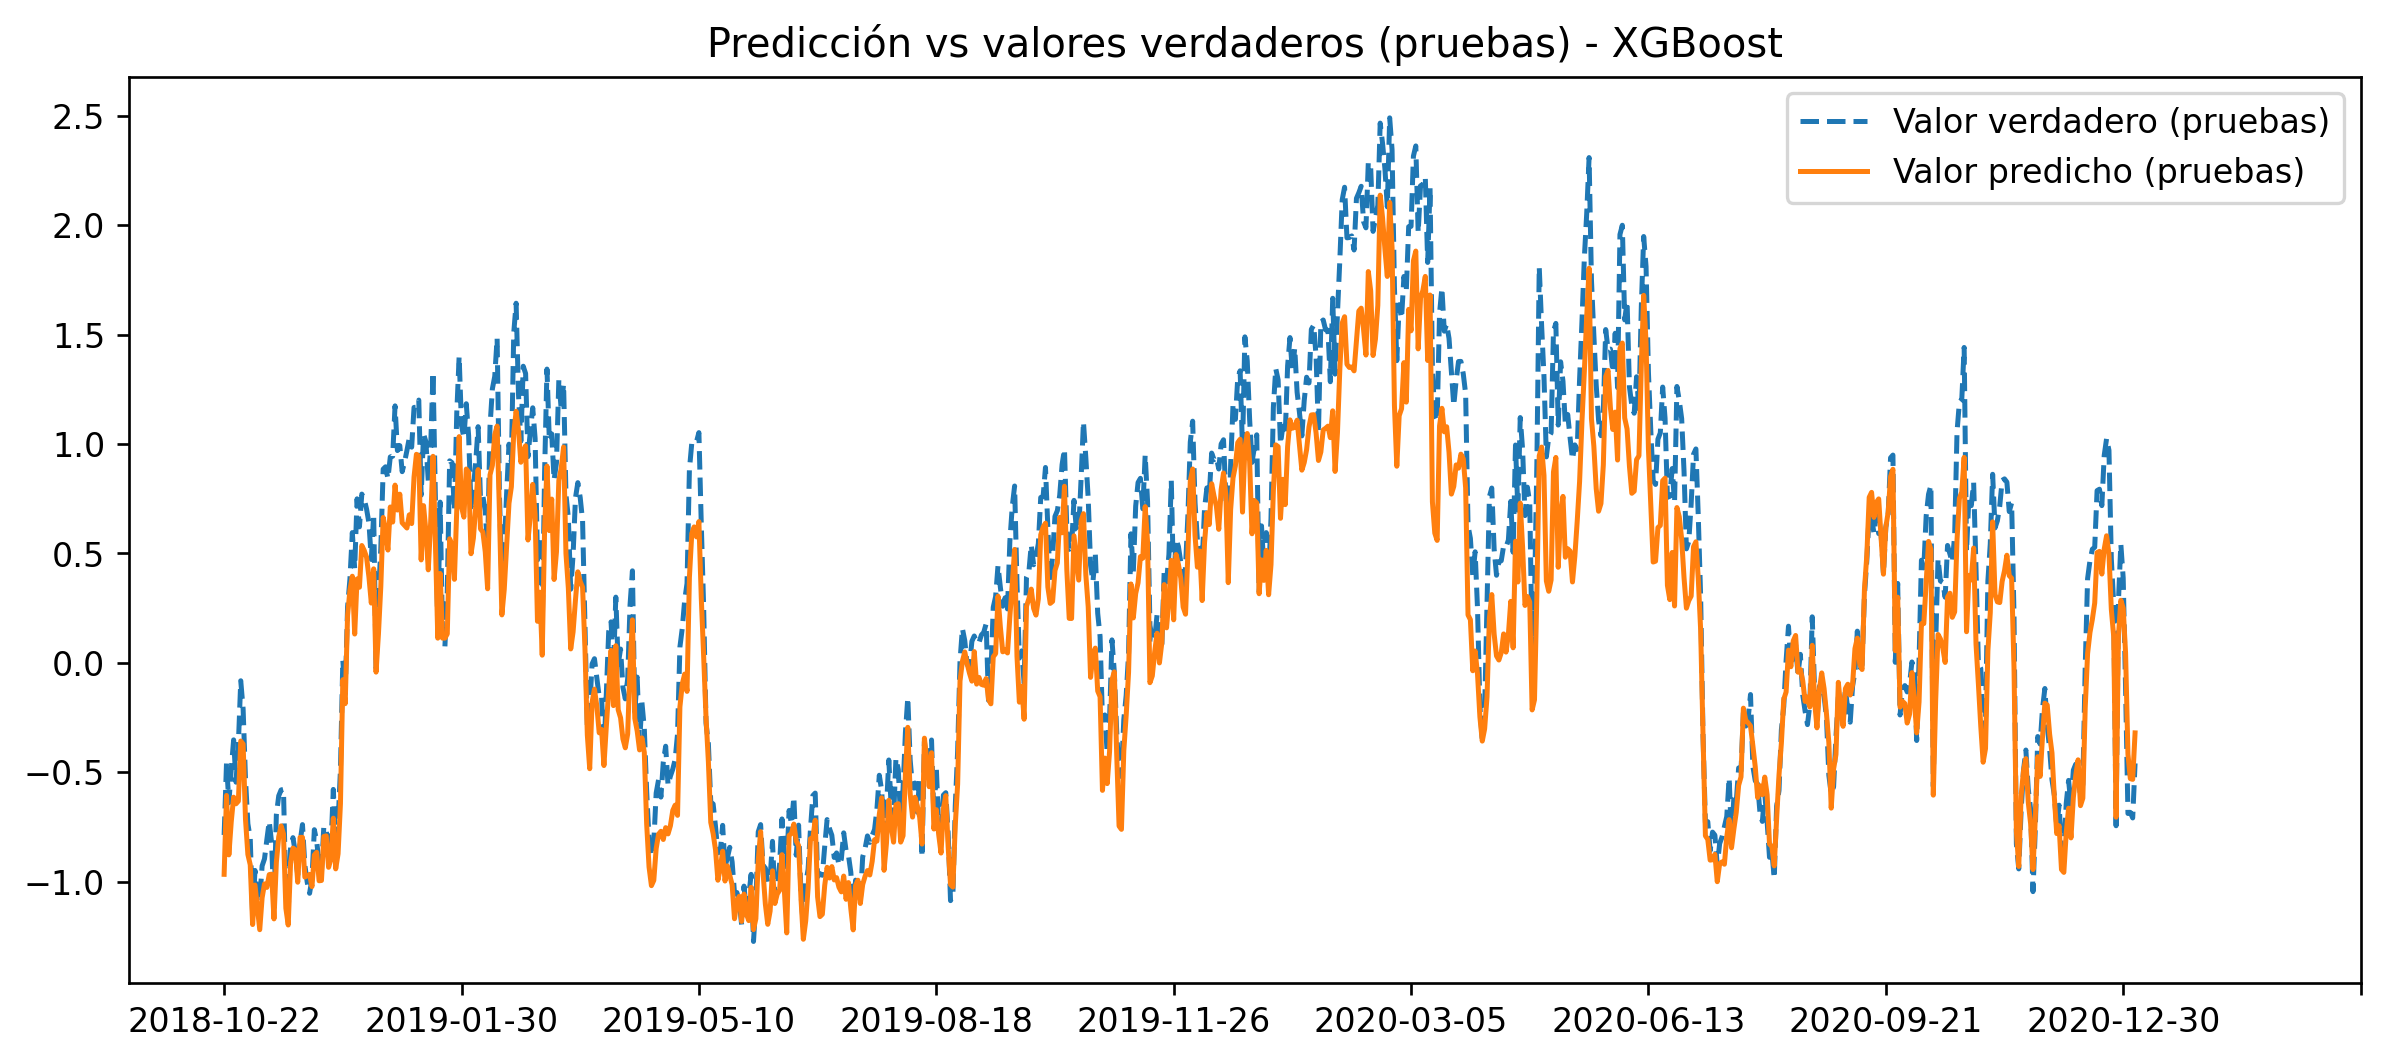

In [329]:
xgb = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, objective='reg:squarederror')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

x = data_test.index[k:]

fig = plt.figure(dpi = 120, figsize = (12, 5))
plt.plot(x, y_test, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_pred, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas) - XGBoost")
plt.xticks(np.arange(0, 1000, 100))
plt.legend();

##### **3.2.6.1 Busqueda de hiperparametros**
---

In [330]:
params_XGB = {'n_estimators': [6,12,24,52,104,500,1000],
          'max_depth': [10,100,1000,2000],
          'reg_alpha': [0.1,0.2]}

In [331]:
tsp = TimeSeriesSplit(n_splits = 3)

gsearch = GridSearchCV(estimator = XGBRegressor(objective='reg:squarederror'), 
                        cv = tsp,
                        param_grid = params_XGB, 
                        verbose = 3)

gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] max_depth=10, n_estimators=6, reg_alpha=0.1 .....................
[CV]  max_depth=10, n_estimators=6, reg_alpha=0.1, score=0.224, total=   0.1s
[CV] max_depth=10, n_estimators=6, reg_alpha=0.1 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=10, n_estimators=6, reg_alpha=0.1, score=-2.242, total=   0.2s
[CV] max_depth=10, n_estimators=6, reg_alpha=0.1 .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=10, n_estimators=6, reg_alpha=0.1, score=-0.537, total=   0.2s
[CV] max_depth=10, n_estimators=6, reg_alpha=0.2 .....................
[CV]  max_depth=10, n_estimators=6, reg_alpha=0.2, score=0.208, total=   0.1s
[CV] max_depth=10, n_estimators=6, reg_alpha=0.2 .....................
[CV]  max_depth=10, n_estimators=6, reg_alpha=0.2, score=-2.270, total=   0.2s
[CV] max_depth=10, n_estimators=6, reg_alpha=0.2 .....................
[CV]  max_depth=10, n_estimators=6, reg_alpha=0.2, score=-0.549, total=   0.2s
[CV] max_depth=10, n_estimators=12, reg_alpha=0.1 ....................
[CV]  max_depth=10, n_estimators=12, reg_alpha=0.1, score=0.402, total=   0.2s
[CV] max_depth=10, n_estimators=12, reg_alpha=0.1 ....................
[CV]  max_depth=10, n_estimators=12, reg_alpha=0.1, score=-0.630, total=   0.3s
[CV] max_depth=10, n_estimators=12, reg_alpha=0.1 ....................
[CV]  max_depth=10, n_estimators=12, reg_alpha=0.1, score=0.626, total=   0.5s
[CV] max_depth=10, n_

[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed: 12.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [10, 100, 1000, 2000],
     

In [332]:
# Los mejores 10 modelos con respecto a su mean_test_score.
best_XGB_models = pd.DataFrame(gsearch.cv_results_).nlargest(10, 'mean_test_score')
best_XGB_models

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
38      11.041729      6.026784  ...        0.145909                1
40      12.624192      6.190356  ...        0.145909                1
52      10.725538      5.572840  ...        0.145909                1
54      12.357708      6.270370  ...        0.145909                1
36       7.835512      4.177193  ...        0.146025                5
50       7.769646      4.058907  ...        0.146025                5
24      10.740509      5.670020  ...        0.145958                7
26      12.436125      6.355070  ...        0.145958                7
22       7.518752      3.829386  ...        0.146116                9
20       3.031936      1.327086  ...        0.147997               10

[10 rows x 14 columns]

In [333]:
X_last = X_test[:1]

# Listas con los datos en y, empezando desde el primer valor de pruebas.
y_last = [] 
y_forward = []

for i in range(len(X_test)):  
  # Valores predichos a partir de datos reales (X_test)
  y_pred_forward = gsearch.predict(X_test[i: i + 1]) 
  y_forward.append(y_pred_forward[0])  

  # Valores predichos a partir de datos predichos y retroalimentados.
  y_pred_last = gsearch.predict(X_last)  # Se predice el valor siguiente a partir de datos predichos previamente.
  y_last.append(y_pred_last[0])          # Guardamos el valor predicho.

  # Creación de la nueva ventana añadiendo la última predicción.
  X_last = np.roll(X_last, -1)           # Desplazamos todos los valores hacia la izquierda con np.roll
  X_last[0,-1] = y_pred_last             # Guardamos el valor predicho en la última posición del arreglo.

#Gráficamos las 2 predicciones distintas en comparación con los valores reales.

test_date_index = data_test.index[k:]
plot_prediction_new(gsearch.best_params_, 
                (y_test, y_forward),
                 test_date_index)
df_one_day_predictions_multi['y_XGB'] = y_forward

#### **3.2.7 Selección del mejor modelo manual**
---

Para seleccionar el mejor módelo procedemos a cálcular las métricas MAE, RMSE, R2.

In [334]:
df_one_day_predictions_multi = df_one_day_predictions_multi.apply(scaler.inverse_transform)
df_one_day_predictions_multi.head(10)

y_test         y_MLP         y_RFR         y_SVM         y_XGB
0  20274.467556  18339.159142  17564.104398  20659.166572  18517.953247
1  24496.597487  22349.274019  22523.421647  24055.113833  21378.524644
2  22172.406380  21168.722808  19496.738038  21976.415466  19718.915391
3  24146.170245  23413.361073  20125.381313  22536.313501  20491.731032
4  25875.372364  24594.478154  22712.186509  24301.550710  22585.146140
5  23381.666174  22900.804712  20480.153185  22736.071701  20403.210163
6  25616.745830  25129.179525  22383.617340  24076.188365  23309.185383
7  29355.265824  27950.741094  24535.128828  27802.480235  25940.196715
8  27687.145910  27451.712892  24443.116680  26568.005136  24212.938622
9  23583.128867  22247.107701  21299.095145  23324.545064  21646.016190

In [335]:
from sklearn.metrics import r2_score
models = ['y_MLP','y_RFR', 'y_SVM', 'y_XGB']
mae_multi = {}
rmse_multi = {}
r2_multi = {}
for m in models:
  mae_multi[m] = mean_absolute_error(df_one_day_predictions_multi['y_test'], df_one_day_predictions_multi[m]) 
  rmse_multi[m] = np.sqrt(mean_squared_error(df_one_day_predictions_multi['y_test'], df_one_day_predictions_multi[m]))
  r2_multi[m] = r2_score(df_one_day_predictions_multi['y_test'], df_one_day_predictions_multi[m]) 

print('mae' + str(mae_multi))
print('rmse'+ str(rmse_multi))
print('r2'+ str(r2_multi))

mae{'y_MLP': 2712.348012762767, 'y_RFR': 3741.3902315758505, 'y_SVM': 1025.889736872446, 'y_XGB': 3133.0386422602564}
rmse{'y_MLP': 3434.803071897928, 'y_RFR': 4336.659216623355, 'y_SVM': 1343.8066098694962, 'y_XGB': 3873.8276136182253}
r2{'y_MLP': 0.9055978712322087, 'y_RFR': 0.8495165657123944, 'y_SVM': 0.9855505389592659, 'y_XGB': 0.8799233166644396}


Ademas organizamos todos los modelos encontrados por las busquedas GridSearch

In [336]:
best_models = best_MLP_models.append(best_RFR_models)
best_models = best_models.append(best_SVM_models)
best_models = best_models.append(best_XGB_models)
best_model = best_models.nlargest(10, 'mean_test_score').head(3)
best_model

mean_fit_time  std_fit_time  ...  param_kernel  param_reg_alpha
220       0.163937      0.090198  ...           rbf              NaN
232       0.167030      0.086584  ...           rbf              NaN
244       0.165017      0.089691  ...           rbf              NaN

[3 rows x 23 columns]

A continuación podemos ver los parámetros del mejor modelo:

In [337]:
best_model['params'].iloc[0]

{'C': 1000, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}

In [338]:
mae_multi

{'y_MLP': 2712.348012762767,
 'y_RFR': 3741.3902315758505,
 'y_SVM': 1025.889736872446,
 'y_XGB': 3133.0386422602564}

In [339]:
rmse_multi

{'y_MLP': 3434.803071897928,
 'y_RFR': 4336.659216623355,
 'y_SVM': 1343.8066098694962,
 'y_XGB': 3873.8276136182253}

In [340]:
r2_multi

{'y_MLP': 0.9055978712322087,
 'y_RFR': 0.8495165657123944,
 'y_SVM': 0.9855505389592659,
 'y_XGB': 0.8799233166644396}

Las anteriores metricas nos sugierern que el mejor modelo es un regresor de Maquinas de Vectores de Soporte con los parametros: {'C': 1000, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}

A continuacion se reentrena el modelo:

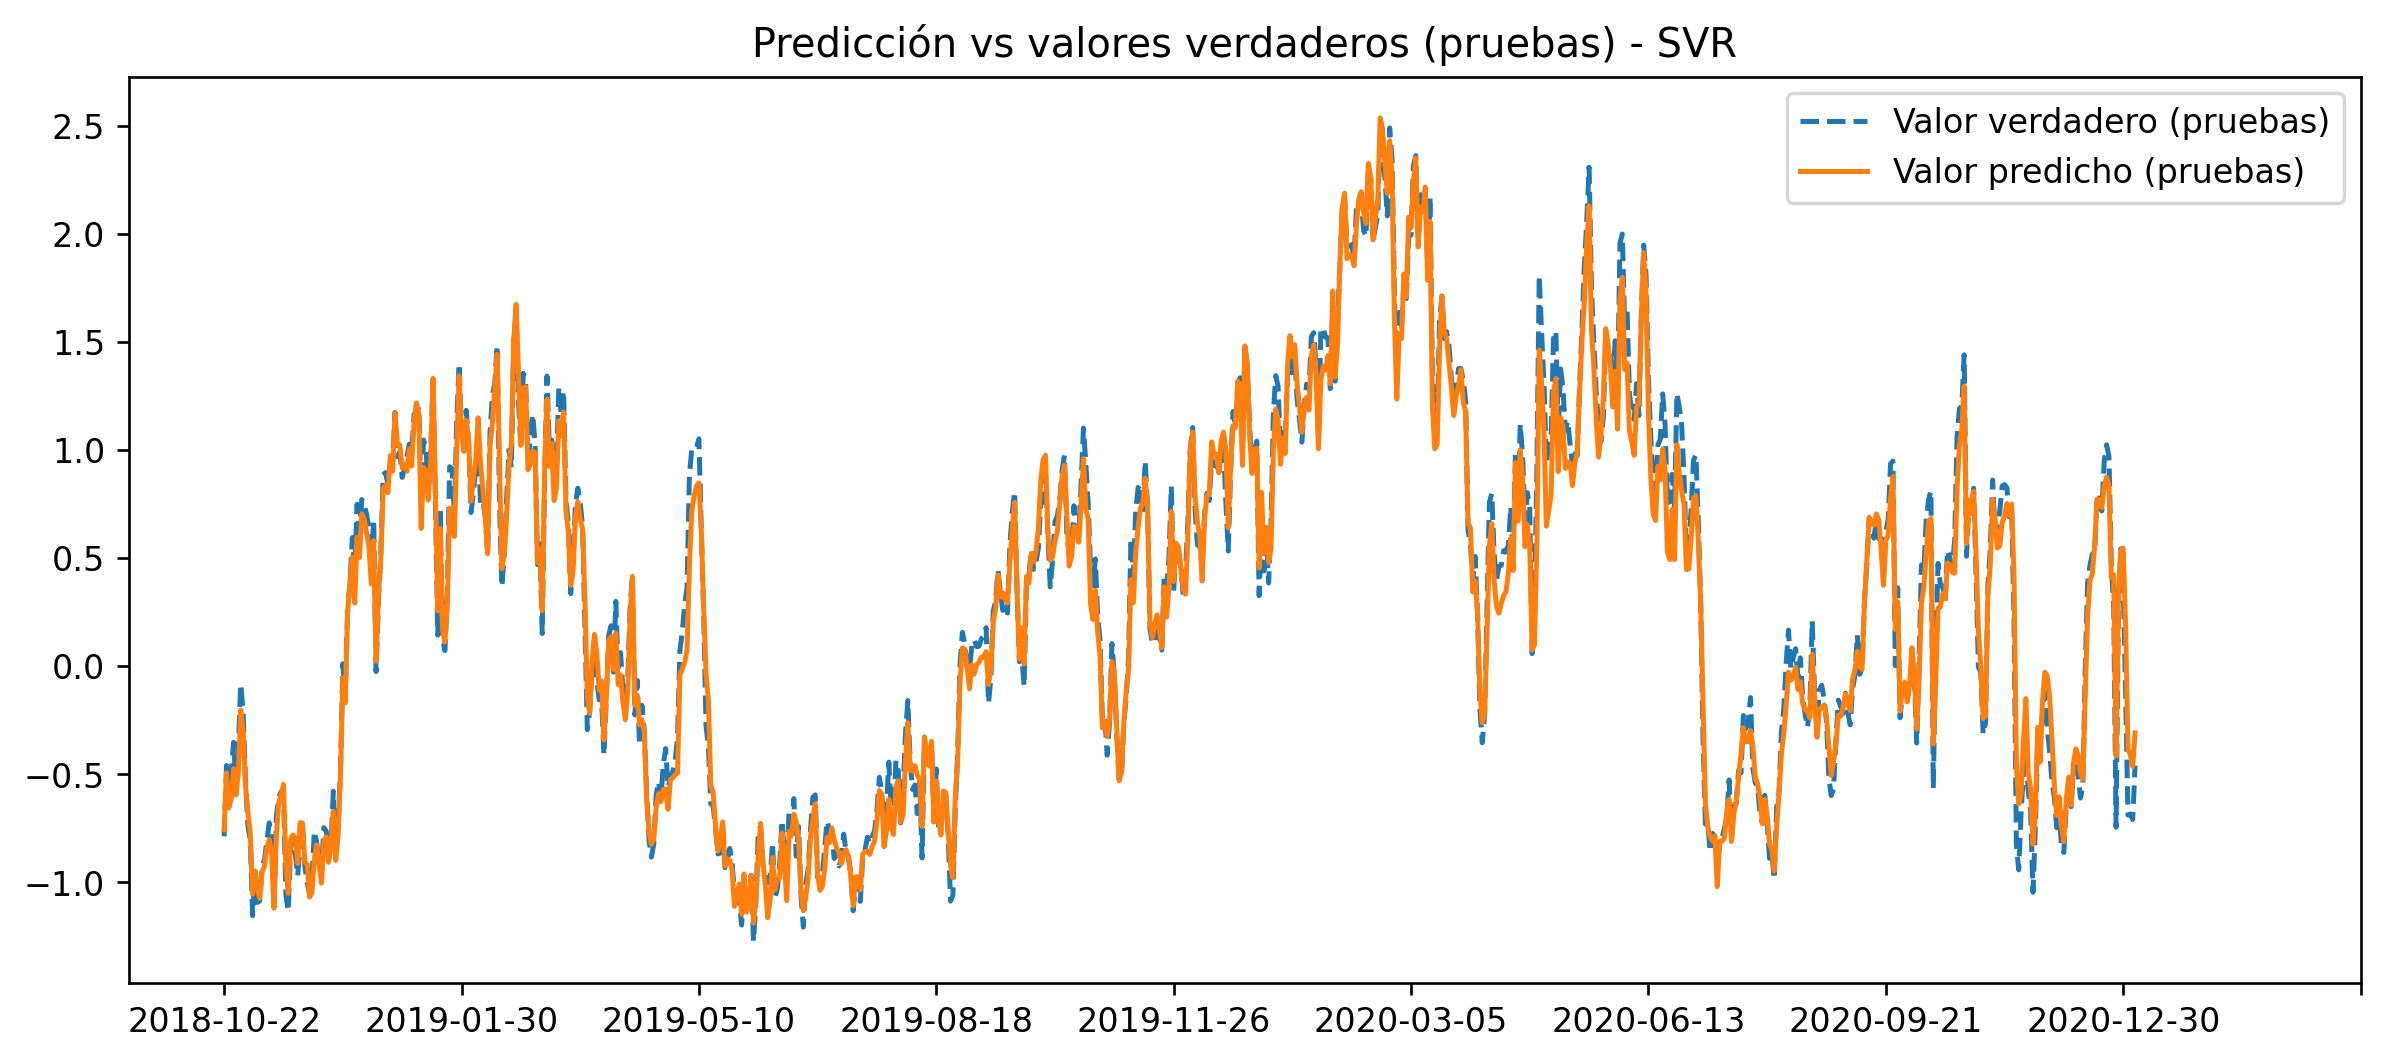

In [341]:
svr_rbf = SVR(C=1000, degree= 2, epsilon= 0.1, gamma= 0.0001, kernel='rbf')
svr_rbf.fit(X_train, y_train)
y_pred = svr_rbf.predict(X_test)
x = data_test.index[k:]

fig = plt.figure(dpi = 120, figsize = (12, 5))
plt.plot(x, y_test, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_pred, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas) - SVR")
plt.xticks(np.arange(0, 1000, 100))
plt.legend();

## **4. Evaluación y Analisis de resultados**
---

### **4.1. Comparación de Modelos Univariado y Multivariado**
---

In [342]:
mae

{'y_MLP': 3105.458657105407,
 'y_RFR': 2569.040413591066,
 'y_SVM': 2421.9078573695597,
 'y_XGB': 2867.375235968814}

In [343]:
mae_multi

{'y_MLP': 2712.348012762767,
 'y_RFR': 3741.3902315758505,
 'y_SVM': 1025.889736872446,
 'y_XGB': 3133.0386422602564}

In [344]:
rmse

{'y_MLP': 4049.1500165009033,
 'y_RFR': 3371.7913766662123,
 'y_SVM': 3227.9042004865105,
 'y_XGB': 3684.563696534092}

In [345]:
rmse_multi

{'y_MLP': 3434.803071897928,
 'y_RFR': 4336.659216623355,
 'y_SVM': 1343.8066098694962,
 'y_XGB': 3873.8276136182253}

In [346]:
r2

{'y_MLP': 0.8688084579529282,
 'y_RFR': 0.9090297279023182,
 'y_SVM': 0.916628161899985,
 'y_XGB': 0.8913698848317108}

In [347]:
r2_multi

{'y_MLP': 0.9055978712322087,
 'y_RFR': 0.8495165657123944,
 'y_SVM': 0.9855505389592659,
 'y_XGB': 0.8799233166644396}

Con base en las métricas anteriormente mencionadas, se puede concluir que para tanto para el problema univariado, como para el problema multivariado, **el mejor modelo es el Support Vector Regressor**.

Es evidente que la predicción mejora al usar más características en $X$.

### **4.2. Siguientes pasos**
---

Los siguientes pasos en este proyecto son:
1. Hacer una busqueda mas extensiva de hiperametros con el objetivo de mejorar las predicciones.
2. Entrenar modelos con diferentes combinaciones de caracteristicas y evaluar si se comporta mejor.
3. Entrenar un modelo que tome una ventana futura mas grande que 1 solo dia, por ejemplo, predecir una semana hacia el futro.


# **Referencias**

1.   Informe Anual XM S.A. E.S.P. https://informeanual.xm.com.co/demo_3/pages/xm/21-capacidad-efectiva-neta.html
2.   https://www.portafolio.co/economia/con-48-termicas-se-reforzara-la-matriz-de-generacion-electrica-541424
3. https://www.xm.com.co/corporativo/Paginas/Nuestra-empresa/que-hacemos.aspx
4. http://unfccc.int/process/transparency-and-reporting/greenhouse-gas-data/greenhouse-gas-data-unfccc/global-warming-potentials
